# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt18_raw/ggH_bbtt*.root', 'root_raw/mt18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt17_raw/ggH_bbtt*.root', 'root_raw/mt17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt16_raw/ggH_bbtt*.root', 'root_raw/mt16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 2b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4184').Filter('bpt_deepcsv_2>20 && bscore_deepcsv_2>0.4184')
    files17[i] = files17[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4941').Filter('bpt_deepcsv_2>20 && bscore_deepcsv_2>0.4941')
    files16[i] = files16[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.6321').Filter('bpt_deepcsv_2>20 && bscore_deepcsv_2>0.6321')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
myb2 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_2,beta_deepcsv_2,bphi_deepcsv_2,bm_deepcsv_2)'
m_b1tt = '(mytt+myb1).M()'
m_b2tt = '(mytt+myb2).M()'
m_bbtt = '(mytt+myb1+myb2).M()'
m_bb = '(myb1+myb2).M()'
m_b1mu = '(mymu+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
m_b2mu = '(mymu+myb2).M()'
m_b2tau = '(mytau+myb2).M()'
m_bbmu = '(myb1+myb2+mymu).M()'
m_bbtau = '(myb1+myb2+mytau).M()'
dm_a = '(m_bb-m_sv)/m_sv'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(mymu,mytau)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b2mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb2)'
dR_b2tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb2)'
dR_bb = 'ROOT::Math::VectorUtil::DeltaR(myb1,myb2)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
dR_b2tt = 'ROOT::Math::VectorUtil::DeltaR(myb2,mytt)'
dR_bbmu = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,mymu)'
dR_bbtau = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,mytau)'
dR_aa = 'ROOT::Math::VectorUtil::DeltaR(mytt,myb1+myb2)'

# define transverse masses mT and D_zeta
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
mT_b2 = 'sqrt(pow(myb2.Pt()+mymet.Pt(),2)-pow(myb2.Px()+mymet.Px(),2)-pow(myb2.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files17[i] = files17[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files16[i] = files16[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 mu+tau trigger requirements
trigger24OR27_18 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_18 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger2027HPS_18 = '(passMu20HPSTau27 && matchMu20HPSTau27_1 && filterMu20HPSTau27_1 && matchMu20HPSTau27_2 && filterMu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb_18 = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027HPS_emb_18 = '(matchEmbFilter_Mu20Tau27_1 && matchEmbFilter_Mu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc_18 = trigger24OR27_18 + str(' or ') + trigger2027HPS_18
trigger_obs_1_18 = trigger2027_18 + str(' or ') + trigger24OR27_18
trigger_obs_2_18 = trigger2027HPS_18 + str(' or ') + trigger24OR27_18
trigger_emb_18 = trigger24OR27_emb_18 + str(' or ') + trigger2027HPS_emb_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) && gen_match_2<3')

files18[1] = files18[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files18[1] = files18[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files18[2] = files18[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1_18 = files18[0].Filter('run<317509').Filter(trigger_obs_1_18)
obs2_18 = files18[0].Filter('run>=317509').Filter(trigger_obs_2_18)
files18[1] = files18[1].Filter(trigger_mc_18)
files18[2] = files18[2].Filter(trigger_emb_18)
files18[3] = files18[3].Filter(trigger_mc_18)

# QCD region
qcd1_18 = obs1_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2_18 = obs2_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 7 ##########################
# 2017 mu+tau trigger requirements
trigger24OR27_17 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_17 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb_17 = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_emb_17 = '(matchEmbFilter_Mu20Tau27_2017_1 && matchEmbFilter_Mu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc_obs_17 = trigger24OR27_17 + str(' or ') + trigger2027_17
trigger_emb_17 = trigger24OR27_emb_17 + str(' or ') + trigger2027_emb_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) && gen_match_2<3')

files17[1] = files17[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files17[1] = files17[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files17[2] = files17[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files17[0] = files17[0].Filter(trigger_mc_obs_17)
files17[1] = files17[1].Filter(trigger_mc_obs_17)
files17[2] = files17[2].Filter(trigger_emb_17)
files17[3] = files17[3].Filter(trigger_mc_obs_17)

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 6 ##########################
# 2016 mu+tau trigger requirements
trigger22_16 = '((passMu22eta2p1 && matchMu22eta2p1_1 && filterMu22eta2p1_1 && pt_1>23) or (passTkMu22eta2p1 && matchTkMu22eta2p1_1 && filterTkMu22eta2p1_1 && pt_1>23) or (passMu22 && matchMu22_1 && filterMu22_1 && pt_1>23) or (passTkMu22 && matchTkMu22_1 && filterTkMu22_1 && pt_1>23))'
trigger1920_16 = '((passMu19Tau20 && matchMu19Tau20_1 && matchMu19Tau20_2 && filterMu19Tau20_1 && filterMu19Tau20_2 && pt_1>20 && pt_1<23 && pt_2>25 && fabs(eta_2)<2.1) or (passMu19Tau20SingleL1 && matchMu19Tau20SingleL1_1 && matchMu19Tau20SingleL1_2 && filterMu19Tau20SingleL1_1 && filterMu19Tau20SingleL1_2 && pt_1>20 && pt_1<23 && pt_2>25 && fabs(eta_2)<2.1))'

trigger_all_16 = trigger22_16 + str(' or ') + trigger1920_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) && gen_match_2<3')

files16[1] = files16[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files16[1] = files16[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16)
files16[1] = files16[1].Filter(trigger_all_16)
files16[2] = files16[2].Filter(trigger_all_16)
files16[3] = files16[3].Filter(trigger_all_16)

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 2b events
feature_list = ['pt_1', 'm_b1tt', 'm_b2tt', 'm_bbtt', 'm_bb', 'm_b1mu', 'm_b1tau', 'm_b2mu', 'm_b2tau', 'dm_a',\
                'm_bbmu', 'm_bbtau', 'dR_tt', 'dR_b1mu', 'dR_b1tau', 'dR_b2mu', 'dR_b2tau', 'dR_bb', 'dR_b1tt', 'dR_b2tt', 'dR_aa',\
                'dR_bbmu','dR_bbtau', 'mT_mu', 'mT_tau', 'mT_b1', 'mT_b2', 'Dzeta',\
                'bpt_deepcsv_1', 'bpt_deepcsv_2']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd1_18 = pd.DataFrame(qcd1_18.AsNumpy(feature_list))
qcd2_18 = pd.DataFrame(qcd2_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18_1.shape: ' + str(qcd1_18.shape))
print('qcd18_2.shape: ' + str(qcd2_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd1_18, qcd2_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (3751, 30)
ZTT18.shape  : (30111, 30)
TT18.shape   : (15013, 30)
qcd18_1.shape: (21472, 30)
qcd18_2.shape: (47039, 30)

sig17.shape  : (3710, 30)
ZTT17.shape  : (18617, 30)
TT17.shape   : (2064, 30)
qcd17.shape  : (41725, 30)

sig16.shape  : (5401, 30)
ZTT16.shape  : (14146, 30)
TT16.shape   : (1577, 30)
qcd16.shape  : (34924, 30)

sig_allyears.shape: (12862, 31)
ZTT_allyears.shape: (62874, 31)
TT_allyears.shape : (18654, 31)
qcd_allyears.shape: (145160, 31)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 3000, random_state = 20)#23.3%
TT_allyears = TT_allyears.sample(n = 5862, random_state = 20)#45.6%
qcd_allyears = qcd_allyears.sample(n = 4000, random_state = 20)#31.1%

# collect all MC as one dataframe, separated from another datafream for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
             pt_1      m_b1tt      m_b2tt      m_bbtt        m_bb      m_b1mu  \
0       27.653065  113.139428  176.301366  210.194223   30.256904   56.323495   
1       37.294136  123.990523  121.047802  174.186058   32.660769   73.031079   
2       48.086967   67.554850   69.080166   98.978725   33.962962   81.093231   
3       44.521755  116.392157  128.955226  185.735511   71.177945  100.878501   
4       26.991787  128.275863  295.062790  329.494001   76.705152   53.692987   
...           ...         ...         ...         ...         ...         ...   
35076  118.986031  238.407813  234.081839  278.236785   74.390009   45.758206   
28930  118.025543  429.181081  323.037438  468.209013   74.379666  246.096769   
3100   152.861740  264.727038  449.310275  478.012291   77.378016   89.380729   
20238   39.545586  122.920916  185.500476  238.969592  129.406401   53.632028   
540     79.630905  193.659350  183.473386  265.268934  102.769279  105.937545   

         m_

## Compare input feature distributions between sig and bkg

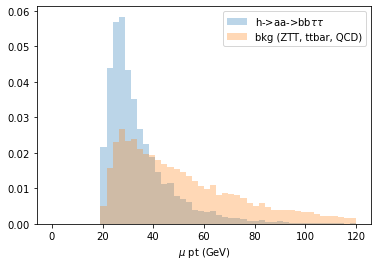

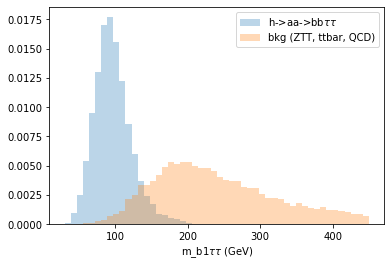

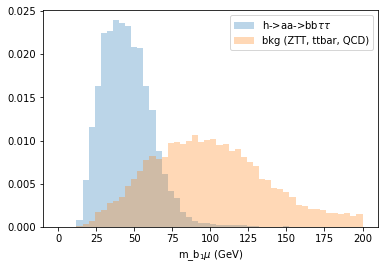

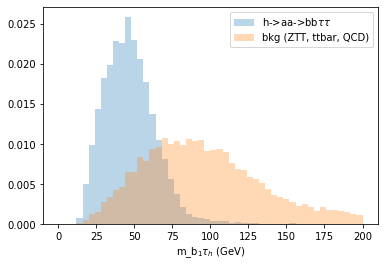

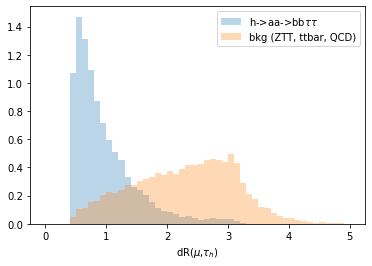

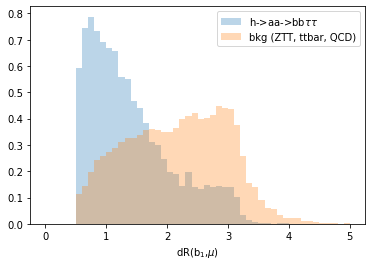

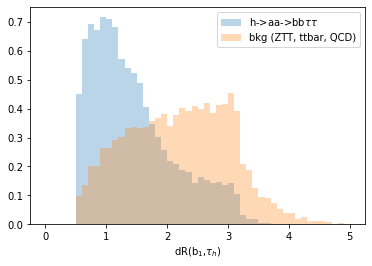

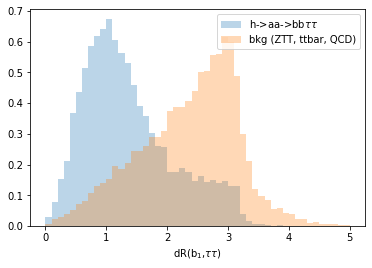

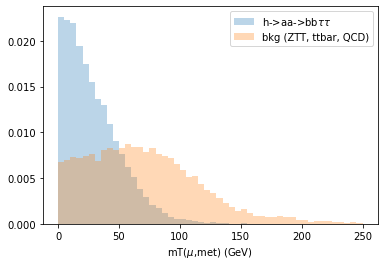

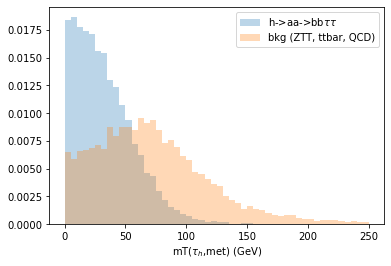

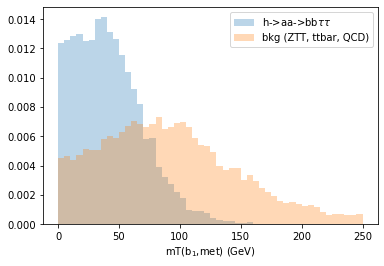

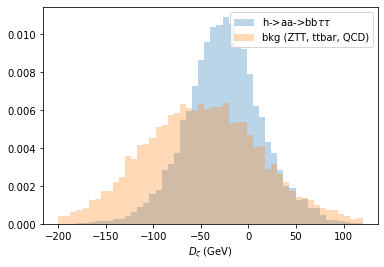

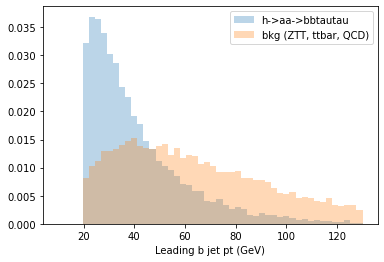

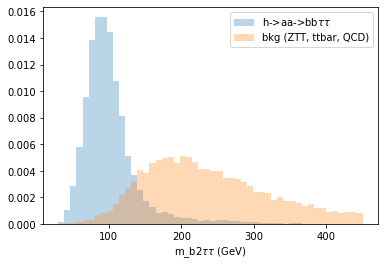

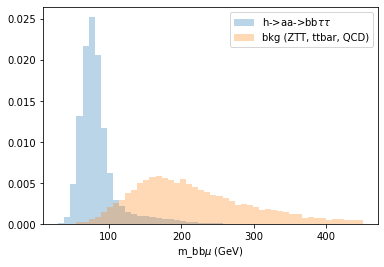

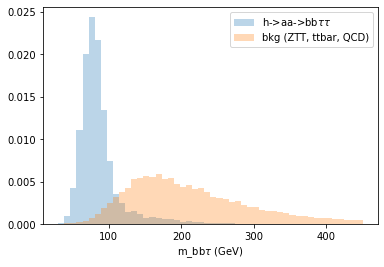

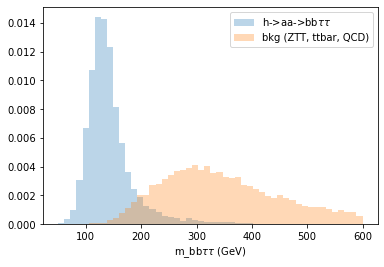

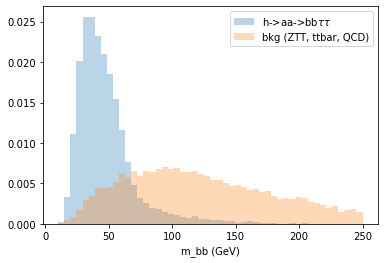

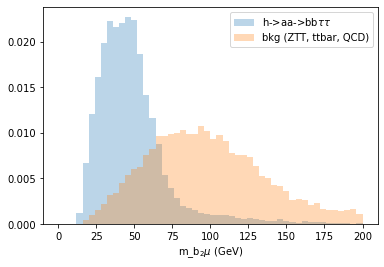

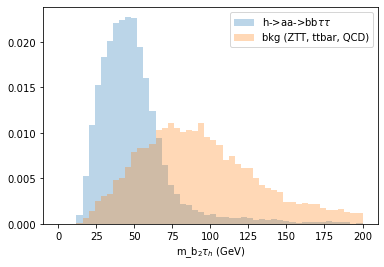

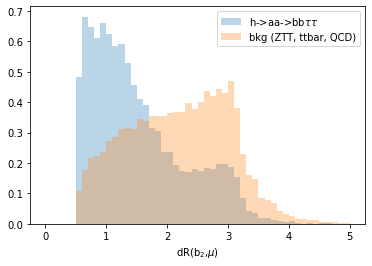

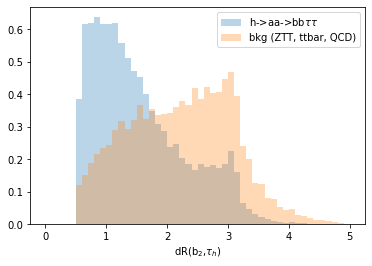

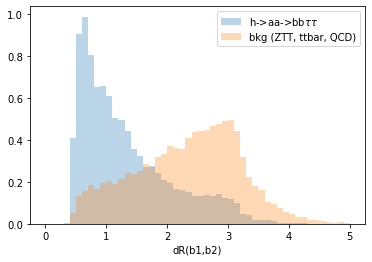

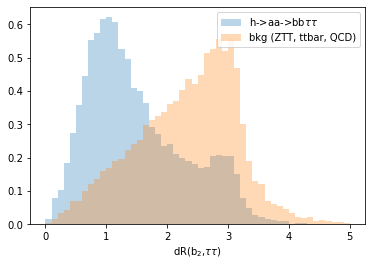

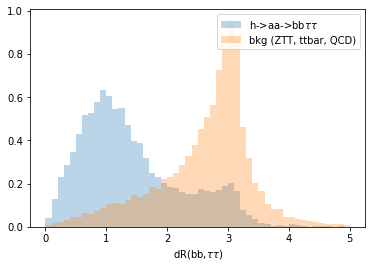

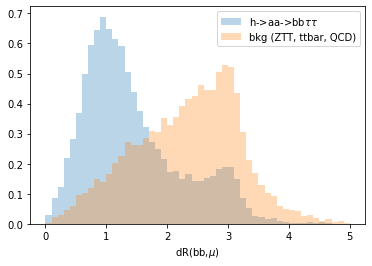

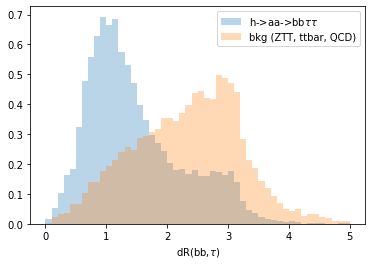

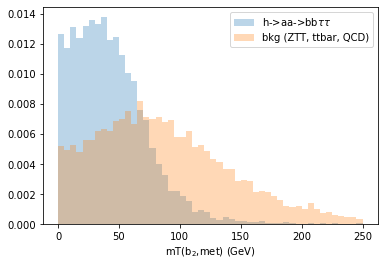

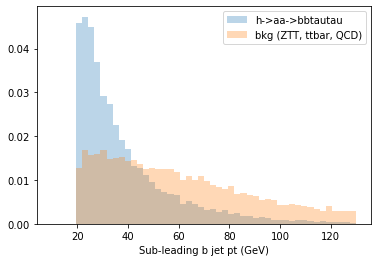

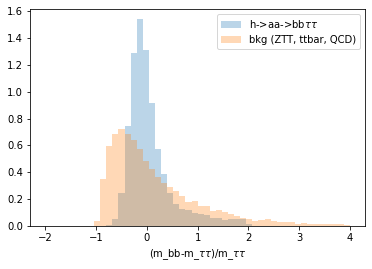

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b1$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR($\mu$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

############## for 2b events
pyplot.hist(sig_allyears['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b2$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b1,b2)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_2$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Sub-leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('(m_bb-m_$\\tau\\tau$)/m_$\\tau\\tau$')
pyplot.show()

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.50/0.25/0.25
X_train.shape: (12862, 30)
Y_train.shape: (12862, 1)
X_val.shape: (6431, 30)
Y_val.shape: (6431, 1)
X_test.shape: (6431, 30)
Y_test.shape: (6431, 1)

Total number of sig/bkg examples: 12862/12862 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 6522/6340 (50.7%/49.3%)
val   : 3208/3223 (49.9%/50.1%)
test  : 3132/3299 (48.7%/51.3%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 25,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 2, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-03-12 14:53:28.755319: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-03-12 14:53:28.756093: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 25, validation_data = (X_val,Y_val), batch_size = 128)

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 1:06 - loss: 0.7085 - accuracy: 0.55 - ETA: 7s - loss: 0.6172 - accuracy: 0.6762 - ETA: 3s - loss: 0.5374 - accuracy: 0.76 - ETA: 2s - loss: 0.4745 - accuracy: 0.80 - ETA: 1s - loss: 0.4240 - accuracy: 0.83 - ETA: 1s - loss: 0.3799 - accuracy: 0.85 - ETA: 0s - loss: 0.3477 - accuracy: 0.86 - ETA: 0s - loss: 0.3213 - accuracy: 0.87 - ETA: 0s - loss: 0.2999 - accuracy: 0.88 - ETA: 0s - loss: 0.2807 - accuracy: 0.89 - ETA: 0s - loss: 0.2679 - accuracy: 0.89 - 1s 115us/sample - loss: 0.2566 - accuracy: 0.9023 - val_loss: 0.1090 - val_accuracy: 0.9575
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.93 - ETA: 0s - loss: 0.1506 - accuracy: 0.93 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - ac

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 51s - loss: 0.8820 - accuracy: 0.453 - ETA: 4s - loss: 0.7314 - accuracy: 0.556 - ETA: 2s - loss: 0.6472 - accuracy: 0.63 - ETA: 1s - loss: 0.5660 - accuracy: 0.70 - ETA: 0s - loss: 0.5098 - accuracy: 0.74 - ETA: 0s - loss: 0.4658 - accuracy: 0.77 - ETA: 0s - loss: 0.4318 - accuracy: 0.79 - ETA: 0s - loss: 0.4079 - accuracy: 0.81 - ETA: 0s - loss: 0.3848 - accuracy: 0.82 - ETA: 0s - loss: 0.3636 - accuracy: 0.83 - 1s 99us/sample - loss: 0.3561 - accuracy: 0.8398 - val_loss: 0.1398 - val_accuracy: 0.9436
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.95 - ETA: 0s - loss: 0.2032 - accuracy: 0.92 - ETA: 0s - loss: 0.1932 - accuracy: 0.92 - ETA: 0s - loss: 0.1818 - accuracy: 0.93 - ETA: 0s - loss: 0.1783 - accuracy: 0.93 - ETA: 0s - loss: 0.1777 - accuracy: 0.93 - ETA: 0s - loss: 0.1738 - accuracy: 0.93 - ETA: 0s - loss: 0.1711 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 52s - loss: 0.7008 - accuracy: 0.515 - ETA: 5s - loss: 0.5963 - accuracy: 0.636 - ETA: 2s - loss: 0.5309 - accuracy: 0.72 - ETA: 1s - loss: 0.4698 - accuracy: 0.78 - ETA: 1s - loss: 0.4188 - accuracy: 0.81 - ETA: 0s - loss: 0.3816 - accuracy: 0.83 - ETA: 0s - loss: 0.3480 - accuracy: 0.85 - ETA: 0s - loss: 0.3230 - accuracy: 0.86 - ETA: 0s - loss: 0.3034 - accuracy: 0.87 - ETA: 0s - loss: 0.2876 - accuracy: 0.88 - ETA: 0s - loss: 0.2770 - accuracy: 0.88 - ETA: 0s - loss: 0.2677 - accuracy: 0.89 - 1s 106us/sample - loss: 0.2667 - accuracy: 0.8927 - val_loss: 0.1053 - val_accuracy: 0.9577
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1386 - accuracy: 0.94 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1211 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 49s - loss: 0.7307 - accuracy: 0.578 - ETA: 4s - loss: 0.5879 - accuracy: 0.704 - ETA: 2s - loss: 0.5004 - accuracy: 0.78 - ETA: 1s - loss: 0.4380 - accuracy: 0.82 - ETA: 1s - loss: 0.3955 - accuracy: 0.84 - ETA: 1s - loss: 0.3592 - accuracy: 0.86 - ETA: 0s - loss: 0.3316 - accuracy: 0.87 - ETA: 0s - loss: 0.3103 - accuracy: 0.88 - ETA: 0s - loss: 0.2907 - accuracy: 0.88 - ETA: 0s - loss: 0.2760 - accuracy: 0.89 - ETA: 0s - loss: 0.2632 - accuracy: 0.89 - ETA: 0s - loss: 0.2503 - accuracy: 0.90 - 1s 105us/sample - loss: 0.2470 - accuracy: 0.9049 - val_loss: 0.1013 - val_accuracy: 0.9605
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.92 - ETA: 0s - loss: 0.1388 - accuracy: 0.94 - ETA: 0s - loss: 0.1350 - accuracy: 0.94 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1261 - accuracy: 0.95 - ETA: 0s - loss: 0.1230 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 50s - loss: 0.6896 - accuracy: 0.546 - ETA: 4s - loss: 0.6051 - accuracy: 0.645 - ETA: 2s - loss: 0.5163 - accuracy: 0.74 - ETA: 1s - loss: 0.4650 - accuracy: 0.78 - ETA: 1s - loss: 0.4134 - accuracy: 0.81 - ETA: 0s - loss: 0.3760 - accuracy: 0.84 - ETA: 0s - loss: 0.3436 - accuracy: 0.85 - ETA: 0s - loss: 0.3192 - accuracy: 0.86 - ETA: 0s - loss: 0.2988 - accuracy: 0.87 - ETA: 0s - loss: 0.2834 - accuracy: 0.88 - ETA: 0s - loss: 0.2698 - accuracy: 0.89 - 1s 100us/sample - loss: 0.2693 - accuracy: 0.8912 - val_loss: 0.1073 - val_accuracy: 0.9577
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.92 - ETA: 0s - loss: 0.1367 - accuracy: 0.94 - ETA: 0s - loss: 0.1335 - accuracy: 0.94 - ETA: 0s - loss: 0.1325 - accuracy: 0.95 - ETA: 0s - loss: 0.1291 - accuracy: 0.95 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1279 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 49s - loss: 0.7654 - accuracy: 0.515 - ETA: 4s - loss: 0.6003 - accuracy: 0.633 - ETA: 2s - loss: 0.5004 - accuracy: 0.74 - ETA: 1s - loss: 0.4318 - accuracy: 0.79 - ETA: 0s - loss: 0.3907 - accuracy: 0.82 - ETA: 0s - loss: 0.3541 - accuracy: 0.84 - ETA: 0s - loss: 0.3311 - accuracy: 0.85 - ETA: 0s - loss: 0.3071 - accuracy: 0.87 - ETA: 0s - loss: 0.2875 - accuracy: 0.88 - ETA: 0s - loss: 0.2707 - accuracy: 0.88 - 1s 98us/sample - loss: 0.2588 - accuracy: 0.8944 - val_loss: 0.1063 - val_accuracy: 0.9600
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1994 - accuracy: 0.93 - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1208 - accuracy: 0.95 - ETA: 0s - loss: 0.1213 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 50s - loss: 0.7958 - accuracy: 0.507 - ETA: 4s - loss: 0.5829 - accuracy: 0.687 - ETA: 2s - loss: 0.5058 - accuracy: 0.75 - ETA: 1s - loss: 0.4471 - accuracy: 0.79 - ETA: 1s - loss: 0.3969 - accuracy: 0.82 - ETA: 0s - loss: 0.3684 - accuracy: 0.84 - ETA: 0s - loss: 0.3455 - accuracy: 0.85 - ETA: 0s - loss: 0.3210 - accuracy: 0.86 - ETA: 0s - loss: 0.3047 - accuracy: 0.87 - ETA: 0s - loss: 0.2893 - accuracy: 0.88 - ETA: 0s - loss: 0.2766 - accuracy: 0.88 - 1s 101us/sample - loss: 0.2713 - accuracy: 0.8905 - val_loss: 0.1128 - val_accuracy: 0.9565
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.96 - ETA: 0s - loss: 0.1378 - accuracy: 0.94 - ETA: 0s - loss: 0.1402 - accuracy: 0.94 - ETA: 0s - loss: 0.1383 - accuracy: 0.94 - ETA: 0s - loss: 0.1356 - accuracy: 0.95 - ETA: 0s - loss: 0.1362 - accuracy: 0.95 - ETA: 0s - loss: 0.1372 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 49s - loss: 0.8208 - accuracy: 0.398 - ETA: 4s - loss: 0.6634 - accuracy: 0.605 - ETA: 2s - loss: 0.5621 - accuracy: 0.71 - ETA: 1s - loss: 0.4885 - accuracy: 0.77 - ETA: 1s - loss: 0.4334 - accuracy: 0.80 - ETA: 0s - loss: 0.3886 - accuracy: 0.82 - ETA: 0s - loss: 0.3531 - accuracy: 0.84 - ETA: 0s - loss: 0.3296 - accuracy: 0.85 - ETA: 0s - loss: 0.3084 - accuracy: 0.86 - ETA: 0s - loss: 0.2899 - accuracy: 0.87 - ETA: 0s - loss: 0.2730 - accuracy: 0.88 - 1s 100us/sample - loss: 0.2656 - accuracy: 0.8902 - val_loss: 0.1015 - val_accuracy: 0.9633
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1242 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 49s - loss: 0.7006 - accuracy: 0.546 - ETA: 4s - loss: 0.5947 - accuracy: 0.701 - ETA: 2s - loss: 0.5132 - accuracy: 0.78 - ETA: 1s - loss: 0.4539 - accuracy: 0.81 - ETA: 1s - loss: 0.3999 - accuracy: 0.84 - ETA: 0s - loss: 0.3603 - accuracy: 0.86 - ETA: 0s - loss: 0.3297 - accuracy: 0.87 - ETA: 0s - loss: 0.3025 - accuracy: 0.88 - ETA: 0s - loss: 0.2843 - accuracy: 0.89 - ETA: 0s - loss: 0.2639 - accuracy: 0.90 - ETA: 0s - loss: 0.2518 - accuracy: 0.90 - 1s 100us/sample - loss: 0.2473 - accuracy: 0.9098 - val_loss: 0.0966 - val_accuracy: 0.9621
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - ETA: 0s - loss: 0.1142 - accuracy: 0.95 - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1108 - accuracy: 0.96 - ETA: 0s - loss: 0.1075 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 49s - loss: 0.7983 - accuracy: 0.414 - ETA: 4s - loss: 0.5959 - accuracy: 0.680 - ETA: 2s - loss: 0.4791 - accuracy: 0.78 - ETA: 1s - loss: 0.4090 - accuracy: 0.82 - ETA: 1s - loss: 0.3598 - accuracy: 0.85 - ETA: 0s - loss: 0.3233 - accuracy: 0.86 - ETA: 0s - loss: 0.2968 - accuracy: 0.87 - ETA: 0s - loss: 0.2740 - accuracy: 0.89 - ETA: 0s - loss: 0.2538 - accuracy: 0.89 - ETA: 0s - loss: 0.2404 - accuracy: 0.90 - ETA: 0s - loss: 0.2290 - accuracy: 0.90 - 1s 103us/sample - loss: 0.2197 - accuracy: 0.9126 - val_loss: 0.0912 - val_accuracy: 0.9656
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.96 - ETA: 0s - loss: 0.1130 - accuracy: 0.95 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.1035 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1055 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 51s - loss: 0.6745 - accuracy: 0.593 - ETA: 5s - loss: 0.5461 - accuracy: 0.742 - ETA: 2s - loss: 0.4569 - accuracy: 0.81 - ETA: 1s - loss: 0.3928 - accuracy: 0.84 - ETA: 1s - loss: 0.3453 - accuracy: 0.87 - ETA: 0s - loss: 0.3120 - accuracy: 0.88 - ETA: 0s - loss: 0.2845 - accuracy: 0.89 - ETA: 0s - loss: 0.2712 - accuracy: 0.90 - ETA: 0s - loss: 0.2532 - accuracy: 0.90 - ETA: 0s - loss: 0.2401 - accuracy: 0.91 - ETA: 0s - loss: 0.2284 - accuracy: 0.91 - ETA: 0s - loss: 0.2204 - accuracy: 0.92 - 1s 106us/sample - loss: 0.2167 - accuracy: 0.9222 - val_loss: 0.0930 - val_accuracy: 0.9639
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.95 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1307 - accuracy: 0.94 - ETA: 0s - loss: 0.1164 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 49s - loss: 0.7162 - accuracy: 0.484 - ETA: 5s - loss: 0.5487 - accuracy: 0.747 - ETA: 2s - loss: 0.4484 - accuracy: 0.82 - ETA: 1s - loss: 0.3897 - accuracy: 0.85 - ETA: 1s - loss: 0.3415 - accuracy: 0.87 - ETA: 0s - loss: 0.3035 - accuracy: 0.88 - ETA: 0s - loss: 0.2770 - accuracy: 0.89 - ETA: 0s - loss: 0.2554 - accuracy: 0.90 - ETA: 0s - loss: 0.2414 - accuracy: 0.90 - ETA: 0s - loss: 0.2281 - accuracy: 0.91 - ETA: 0s - loss: 0.2153 - accuracy: 0.92 - ETA: 0s - loss: 0.2058 - accuracy: 0.92 - 1s 104us/sample - loss: 0.2042 - accuracy: 0.9243 - val_loss: 0.0917 - val_accuracy: 0.9638
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.93 - ETA: 0s - loss: 0.1033 - accuracy: 0.95 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0996 - accuracy: 0.96 - ETA: 0s - loss: 0.0976 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 4/9
12862/12862 [==============================] - ETA: 49s - loss: 0.7684 - accuracy: 0.578 - ETA: 5s - loss: 0.5912 - accuracy: 0.668 - ETA: 2s - loss: 0.4728 - accuracy: 0.77 - ETA: 1s - loss: 0.3944 - accuracy: 0.83 - ETA: 1s - loss: 0.3463 - accuracy: 0.85 - ETA: 0s - loss: 0.3099 - accuracy: 0.87 - ETA: 0s - loss: 0.2850 - accuracy: 0.88 - ETA: 0s - loss: 0.2650 - accuracy: 0.89 - ETA: 0s - loss: 0.2526 - accuracy: 0.89 - ETA: 0s - loss: 0.2393 - accuracy: 0.90 - ETA: 0s - loss: 0.2274 - accuracy: 0.90 - ETA: 0s - loss: 0.2192 - accuracy: 0.91 - ETA: 0s - loss: 0.2113 - accuracy: 0.91 - 1s 111us/sample - loss: 0.2066 - accuracy: 0.9179 - val_loss: 0.0867 - val_accuracy: 0.9708
Epoch 5/9
12862/12862 [==============================] - ETA: 0s - loss: 0.1117 - accuracy: 0.95 - ETA: 0s - loss: 0.1047 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1032 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 4/9
12862/12862 [==============================] - ETA: 56s - loss: 0.7783 - accuracy: 0.531 - ETA: 6s - loss: 0.6164 - accuracy: 0.609 - ETA: 3s - loss: 0.5206 - accuracy: 0.73 - ETA: 2s - loss: 0.4366 - accuracy: 0.79 - ETA: 1s - loss: 0.3839 - accuracy: 0.83 - ETA: 1s - loss: 0.3433 - accuracy: 0.85 - ETA: 0s - loss: 0.3128 - accuracy: 0.86 - ETA: 0s - loss: 0.2876 - accuracy: 0.87 - ETA: 0s - loss: 0.2721 - accuracy: 0.88 - ETA: 0s - loss: 0.2540 - accuracy: 0.89 - ETA: 0s - loss: 0.2388 - accuracy: 0.90 - ETA: 0s - loss: 0.2271 - accuracy: 0.90 - 1s 109us/sample - loss: 0.2218 - accuracy: 0.9086 - val_loss: 0.0979 - val_accuracy: 0.9588
Epoch 5/9
12862/12862 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.1180 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 0s - loss: 0.1105 - accuracy: 0.95 - ETA: 0s - loss: 0.1090 - accuracy: 0.95 - ETA: 0s - loss: 0.1112 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 4/9
12862/12862 [==============================] - ETA: 50s - loss: 0.7019 - accuracy: 0.585 - ETA: 4s - loss: 0.5830 - accuracy: 0.753 - ETA: 2s - loss: 0.4919 - accuracy: 0.82 - ETA: 1s - loss: 0.4206 - accuracy: 0.86 - ETA: 1s - loss: 0.3678 - accuracy: 0.87 - ETA: 0s - loss: 0.3336 - accuracy: 0.88 - ETA: 0s - loss: 0.3092 - accuracy: 0.89 - ETA: 0s - loss: 0.2863 - accuracy: 0.90 - ETA: 0s - loss: 0.2734 - accuracy: 0.90 - ETA: 0s - loss: 0.2586 - accuracy: 0.91 - ETA: 0s - loss: 0.2479 - accuracy: 0.91 - 1s 102us/sample - loss: 0.2419 - accuracy: 0.9168 - val_loss: 0.1028 - val_accuracy: 0.9628
Epoch 5/9
12862/12862 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.94 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - ETA: 0s - loss: 0.1112 - accuracy: 0.95 - ETA: 0s - loss: 0.1083 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 4/9
12862/12862 [==============================] - ETA: 50s - loss: 0.7751 - accuracy: 0.476 - ETA: 4s - loss: 0.6753 - accuracy: 0.599 - ETA: 2s - loss: 0.5449 - accuracy: 0.71 - ETA: 1s - loss: 0.4600 - accuracy: 0.78 - ETA: 1s - loss: 0.4063 - accuracy: 0.81 - ETA: 0s - loss: 0.3686 - accuracy: 0.83 - ETA: 0s - loss: 0.3369 - accuracy: 0.85 - ETA: 0s - loss: 0.3147 - accuracy: 0.86 - ETA: 0s - loss: 0.2956 - accuracy: 0.87 - ETA: 0s - loss: 0.2789 - accuracy: 0.88 - ETA: 0s - loss: 0.2657 - accuracy: 0.88 - 1s 99us/sample - loss: 0.2653 - accuracy: 0.8891 - val_loss: 0.1045 - val_accuracy: 0.9593
Epoch 5/9
12862/12862 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.96 - ETA: 0s - loss: 0.1195 - accuracy: 0.96 - ETA: 0s - loss: 0.1196 - accuracy: 0.95 - ETA: 0s - loss: 0.1269 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 10/25
12862/12862 [==============================] - ETA: 50s - loss: 0.7967 - accuracy: 0.390 - ETA: 5s - loss: 0.6390 - accuracy: 0.611 - ETA: 2s - loss: 0.5209 - accuracy: 0.74 - ETA: 1s - loss: 0.4487 - accuracy: 0.79 - ETA: 1s - loss: 0.3907 - accuracy: 0.83 - ETA: 1s - loss: 0.3471 - accuracy: 0.85 - ETA: 0s - loss: 0.3110 - accuracy: 0.87 - ETA: 0s - loss: 0.2855 - accuracy: 0.88 - ETA: 0s - loss: 0.2686 - accuracy: 0.89 - ETA: 0s - loss: 0.2527 - accuracy: 0.89 - ETA: 0s - loss: 0.2404 - accuracy: 0.90 - ETA: 0s - loss: 0.2286 - accuracy: 0.90 - 1s 106us/sample - loss: 0.2236 - accuracy: 0.9094 - val_loss: 0.0964 - val_accuracy: 0.9605
Epoch 11/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1076 - accuracy: 0.95 - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.1002 - accuracy: 0.96 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.1028 -

12862/12862 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.94 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0574 - accuracy: 0.97 - ETA: 0s - loss: 0.0570 - accuracy: 0.98 - ETA: 0s - loss: 0.0590 - accuracy: 0.97 - ETA: 0s - loss: 0.0614 - accuracy: 0.97 - ETA: 0s - loss: 0.0610 - accuracy: 0.97 - ETA: 0s - loss: 0.0612 - accuracy: 0.97 - ETA: 0s - loss: 0.0591 - accuracy: 0.97 - ETA: 0s - loss: 0.0593 - accuracy: 0.97 - ETA: 0s - loss: 0.0597 - accuracy: 0.97 - ETA: 0s - loss: 0.0595 - accuracy: 0.97 - 1s 55us/sample - loss: 0.0596 - accuracy: 0.9780 - val_loss: 0.0550 - val_accuracy: 0.9795
Epoch 23/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.99 - ETA: 0s - loss: 0.0547 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - ETA: 0s - loss: 0.0656 - accuracy: 0.97 - ETA: 0s - loss: 0.0636 - accuracy: 0.97 - ETA: 0s - loss: 0.0635 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 10/25
12862/12862 [==============================] - ETA: 50s - loss: 0.7507 - accuracy: 0.437 - ETA: 5s - loss: 0.6312 - accuracy: 0.629 - ETA: 2s - loss: 0.5408 - accuracy: 0.74 - ETA: 1s - loss: 0.4679 - accuracy: 0.80 - ETA: 1s - loss: 0.4025 - accuracy: 0.83 - ETA: 0s - loss: 0.3675 - accuracy: 0.85 - ETA: 0s - loss: 0.3347 - accuracy: 0.86 - ETA: 0s - loss: 0.3104 - accuracy: 0.87 - ETA: 0s - loss: 0.2870 - accuracy: 0.88 - ETA: 0s - loss: 0.2695 - accuracy: 0.89 - ETA: 0s - loss: 0.2554 - accuracy: 0.89 - 1s 103us/sample - loss: 0.2427 - accuracy: 0.9051 - val_loss: 0.0964 - val_accuracy: 0.9635
Epoch 11/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.96 - ETA: 0s - loss: 0.1099 - accuracy: 0.96 - ETA: 0s - loss: 0.1152 - accuracy: 0.95 - ETA: 0s - loss: 0.1113 - accuracy: 0.95 - ETA: 0s - loss: 0.1076 - accuracy: 0.95 - ETA: 0s - loss: 0.1047 - accuracy: 0.95 - ETA: 0s - loss: 0.1055 -

Epoch 23/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.96 - ETA: 0s - loss: 0.0612 - accuracy: 0.97 - ETA: 0s - loss: 0.0571 - accuracy: 0.97 - ETA: 0s - loss: 0.0608 - accuracy: 0.97 - ETA: 0s - loss: 0.0613 - accuracy: 0.97 - ETA: 0s - loss: 0.0643 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0662 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accuracy: 0.97 - 1s 53us/sample - loss: 0.0642 - accuracy: 0.9764 - val_loss: 0.0572 - val_accuracy: 0.9801
Epoch 24/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.98 - ETA: 0s - loss: 0.0638 - accuracy: 0.97 - ETA: 0s - loss: 0.0706 - accuracy: 0.97 - ETA: 0s - loss: 0.0708 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0655 - accuracy: 0.97 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/9
12862/12862 [==============================] - ETA: 50s - loss: 0.9136 - accuracy: 0.359 - ETA: 5s - loss: 0.6862 - accuracy: 0.583 - ETA: 2s - loss: 0.5826 - accuracy: 0.69 - ETA: 1s - loss: 0.5024 - accuracy: 0.75 - ETA: 1s - loss: 0.4456 - accuracy: 0.79 - ETA: 0s - loss: 0.4010 - accuracy: 0.81 - ETA: 0s - loss: 0.3670 - accuracy: 0.83 - ETA: 0s - loss: 0.3373 - accuracy: 0.85 - ETA: 0s - loss: 0.3164 - accuracy: 0.86 - ETA: 0s - loss: 0.2951 - accuracy: 0.87 - ETA: 0s - loss: 0.2817 - accuracy: 0.88 - 1s 102us/sample - loss: 0.2713 - accuracy: 0.8869 - val_loss: 0.1052 - val_accuracy: 0.9602
Epoch 2/9
12862/12862 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 1.00 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1230 - accuracy: 0.95 - ETA: 0s - loss: 0.1206 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/9
12862/12862 [==============================] - ETA: 50s - loss: 0.7583 - accuracy: 0.500 - ETA: 5s - loss: 0.6257 - accuracy: 0.660 - ETA: 2s - loss: 0.5133 - accuracy: 0.77 - ETA: 1s - loss: 0.4395 - accuracy: 0.81 - ETA: 1s - loss: 0.3855 - accuracy: 0.84 - ETA: 0s - loss: 0.3472 - accuracy: 0.86 - ETA: 0s - loss: 0.3192 - accuracy: 0.87 - ETA: 0s - loss: 0.2996 - accuracy: 0.88 - ETA: 0s - loss: 0.2781 - accuracy: 0.89 - ETA: 0s - loss: 0.2619 - accuracy: 0.90 - ETA: 0s - loss: 0.2468 - accuracy: 0.90 - ETA: 0s - loss: 0.2344 - accuracy: 0.91 - 1s 103us/sample - loss: 0.2337 - accuracy: 0.9112 - val_loss: 0.0972 - val_accuracy: 0.9630
Epoch 2/9
12862/12862 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.92 - ETA: 0s - loss: 0.1287 - accuracy: 0.94 - ETA: 0s - loss: 0.1172 - accuracy: 0.95 - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - ETA: 0s - loss: 0.1211 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/9
12862/12862 [==============================] - ETA: 51s - loss: 0.6765 - accuracy: 0.625 - ETA: 5s - loss: 0.5719 - accuracy: 0.732 - ETA: 2s - loss: 0.5031 - accuracy: 0.79 - ETA: 1s - loss: 0.4442 - accuracy: 0.83 - ETA: 1s - loss: 0.3994 - accuracy: 0.85 - ETA: 0s - loss: 0.3601 - accuracy: 0.87 - ETA: 0s - loss: 0.3306 - accuracy: 0.88 - ETA: 0s - loss: 0.3056 - accuracy: 0.89 - ETA: 0s - loss: 0.2874 - accuracy: 0.90 - ETA: 0s - loss: 0.2728 - accuracy: 0.90 - ETA: 0s - loss: 0.2592 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2528 - accuracy: 0.9118 - val_loss: 0.1066 - val_accuracy: 0.9586
Epoch 2/9
12862/12862 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.94 - ETA: 0s - loss: 0.1142 - accuracy: 0.96 - ETA: 0s - loss: 0.1211 - accuracy: 0.96 - ETA: 0s - loss: 0.1198 - accuracy: 0.96 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/9
12862/12862 [==============================] - ETA: 51s - loss: 0.8939 - accuracy: 0.523 - ETA: 5s - loss: 0.6167 - accuracy: 0.707 - ETA: 2s - loss: 0.5123 - accuracy: 0.78 - ETA: 1s - loss: 0.4347 - accuracy: 0.82 - ETA: 1s - loss: 0.3816 - accuracy: 0.85 - ETA: 0s - loss: 0.3465 - accuracy: 0.87 - ETA: 0s - loss: 0.3164 - accuracy: 0.88 - ETA: 0s - loss: 0.2914 - accuracy: 0.89 - ETA: 0s - loss: 0.2712 - accuracy: 0.90 - ETA: 0s - loss: 0.2550 - accuracy: 0.90 - ETA: 0s - loss: 0.2428 - accuracy: 0.91 - 1s 100us/sample - loss: 0.2415 - accuracy: 0.9124 - val_loss: 0.0988 - val_accuracy: 0.9628
Epoch 2/9
12862/12862 [==============================] - ETA: 0s - loss: 0.0561 - accuracy: 0.99 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1126 - accuracy: 0.95 - ETA: 0s - loss: 0.1142 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/9
12862/12862 [==============================] - ETA: 50s - loss: 0.8202 - accuracy: 0.445 - ETA: 5s - loss: 0.6400 - accuracy: 0.649 - ETA: 2s - loss: 0.5342 - accuracy: 0.74 - ETA: 1s - loss: 0.4626 - accuracy: 0.78 - ETA: 1s - loss: 0.4084 - accuracy: 0.82 - ETA: 0s - loss: 0.3644 - accuracy: 0.84 - ETA: 0s - loss: 0.3306 - accuracy: 0.86 - ETA: 0s - loss: 0.3063 - accuracy: 0.87 - ETA: 0s - loss: 0.2863 - accuracy: 0.88 - ETA: 0s - loss: 0.2672 - accuracy: 0.89 - ETA: 0s - loss: 0.2547 - accuracy: 0.89 - 1s 102us/sample - loss: 0.2471 - accuracy: 0.8991 - val_loss: 0.0951 - val_accuracy: 0.9633
Epoch 2/9
12862/12862 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.96 - ETA: 0s - loss: 0.1247 - accuracy: 0.96 - ETA: 0s - loss: 0.1244 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.96 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - loss: 0.1138 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/9
12862/12862 [==============================] - ETA: 51s - loss: 0.7080 - accuracy: 0.570 - ETA: 4s - loss: 0.5816 - accuracy: 0.701 - ETA: 2s - loss: 0.4838 - accuracy: 0.78 - ETA: 1s - loss: 0.4183 - accuracy: 0.82 - ETA: 1s - loss: 0.3718 - accuracy: 0.84 - ETA: 0s - loss: 0.3383 - accuracy: 0.86 - ETA: 0s - loss: 0.3105 - accuracy: 0.87 - ETA: 0s - loss: 0.2898 - accuracy: 0.88 - ETA: 0s - loss: 0.2730 - accuracy: 0.89 - ETA: 0s - loss: 0.2583 - accuracy: 0.89 - ETA: 0s - loss: 0.2469 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2438 - accuracy: 0.9059 - val_loss: 0.1005 - val_accuracy: 0.9617
Epoch 2/9
12862/12862 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.96 - ETA: 0s - loss: 0.1302 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 10/25
12862/12862 [==============================] - ETA: 50s - loss: 0.6597 - accuracy: 0.539 - ETA: 4s - loss: 0.5630 - accuracy: 0.715 - ETA: 2s - loss: 0.4824 - accuracy: 0.79 - ETA: 1s - loss: 0.4404 - accuracy: 0.81 - ETA: 1s - loss: 0.4035 - accuracy: 0.84 - ETA: 1s - loss: 0.3634 - accuracy: 0.86 - ETA: 0s - loss: 0.3346 - accuracy: 0.87 - ETA: 0s - loss: 0.3099 - accuracy: 0.88 - ETA: 0s - loss: 0.2914 - accuracy: 0.89 - ETA: 0s - loss: 0.2743 - accuracy: 0.89 - ETA: 0s - loss: 0.2603 - accuracy: 0.90 - ETA: 0s - loss: 0.2506 - accuracy: 0.90 - 1s 105us/sample - loss: 0.2468 - accuracy: 0.9083 - val_loss: 0.1048 - val_accuracy: 0.9600
Epoch 11/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.92 - ETA: 0s - loss: 0.1341 - accuracy: 0.95 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 -

12862/12862 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.96 - ETA: 0s - loss: 0.0611 - accuracy: 0.98 - ETA: 0s - loss: 0.0674 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0673 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0635 - accuracy: 0.97 - ETA: 0s - loss: 0.0629 - accuracy: 0.97 - ETA: 0s - loss: 0.0622 - accuracy: 0.97 - 1s 51us/sample - loss: 0.0625 - accuracy: 0.9772 - val_loss: 0.0568 - val_accuracy: 0.9795
Epoch 24/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.96 - ETA: 0s - loss: 0.0545 - accuracy: 0.98 - ETA: 0s - loss: 0.0552 - accuracy: 0.97 - ETA: 0s - loss: 0.0584 - accuracy: 0.97 - ETA: 0s - loss: 0.0579 - accuracy: 0.97 - ETA: 0s - loss: 0.0581 - accuracy: 0.97 - ETA: 0s - loss: 0.0577 - accuracy: 0.97 - ETA: 0s - loss: 0.0620 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 10/25
12862/12862 [==============================] - ETA: 50s - loss: 0.6537 - accuracy: 0.515 - ETA: 4s - loss: 0.5885 - accuracy: 0.654 - ETA: 2s - loss: 0.4924 - accuracy: 0.74 - ETA: 1s - loss: 0.4255 - accuracy: 0.80 - ETA: 1s - loss: 0.3790 - accuracy: 0.82 - ETA: 0s - loss: 0.3426 - accuracy: 0.84 - ETA: 0s - loss: 0.3105 - accuracy: 0.86 - ETA: 0s - loss: 0.2872 - accuracy: 0.87 - ETA: 0s - loss: 0.2699 - accuracy: 0.88 - ETA: 0s - loss: 0.2530 - accuracy: 0.89 - ETA: 0s - loss: 0.2400 - accuracy: 0.90 - 1s 102us/sample - loss: 0.2344 - accuracy: 0.9046 - val_loss: 0.0986 - val_accuracy: 0.9628
Epoch 11/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.94 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1359 - accuracy: 0.94 - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - ETA: 0s - loss: 0.1243 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 -

12862/12862 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.97 - ETA: 0s - loss: 0.0513 - accuracy: 0.98 - ETA: 0s - loss: 0.0630 - accuracy: 0.97 - ETA: 0s - loss: 0.0604 - accuracy: 0.97 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0665 - accuracy: 0.97 - ETA: 0s - loss: 0.0657 - accuracy: 0.97 - ETA: 0s - loss: 0.0655 - accuracy: 0.97 - ETA: 0s - loss: 0.0665 - accuracy: 0.97 - ETA: 0s - loss: 0.0662 - accuracy: 0.97 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - 1s 51us/sample - loss: 0.0661 - accuracy: 0.9752 - val_loss: 0.0572 - val_accuracy: 0.9793
Epoch 24/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.96 - ETA: 0s - loss: 0.0573 - accuracy: 0.97 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.0601 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0602 - accuracy: 0.97 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/25
12862/12862 [==============================] - ETA: 51s - loss: 0.8622 - accuracy: 0.453 - ETA: 4s - loss: 0.6462 - accuracy: 0.654 - ETA: 2s - loss: 0.5493 - accuracy: 0.74 - ETA: 1s - loss: 0.4790 - accuracy: 0.78 - ETA: 1s - loss: 0.4281 - accuracy: 0.82 - ETA: 0s - loss: 0.3936 - accuracy: 0.83 - ETA: 0s - loss: 0.3653 - accuracy: 0.85 - ETA: 0s - loss: 0.3418 - accuracy: 0.86 - ETA: 0s - loss: 0.3180 - accuracy: 0.87 - ETA: 0s - loss: 0.3010 - accuracy: 0.88 - ETA: 0s - loss: 0.2841 - accuracy: 0.88 - 1s 103us/sample - loss: 0.2741 - accuracy: 0.8936 - val_loss: 0.1121 - val_accuracy: 0.9572
Epoch 2/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.93 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - ETA: 0s - loss: 0.1287 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.96 - ETA: 0s - loss: 0.0824 - accuracy: 0.96 - ETA: 0s - loss: 0.0707 - accuracy: 0.97 - ETA: 0s - loss: 0.0714 - accuracy: 0.97 - ETA: 0s - loss: 0.0711 - accuracy: 0.97 - ETA: 0s - loss: 0.0699 - accuracy: 0.97 - ETA: 0s - loss: 0.0699 - accuracy: 0.97 - ETA: 0s - loss: 0.0693 - accuracy: 0.97 - ETA: 0s - loss: 0.0680 - accuracy: 0.97 - ETA: 0s - loss: 0.0701 - accuracy: 0.97 - ETA: 0s - loss: 0.0687 - accuracy: 0.97 - 1s 53us/sample - loss: 0.0684 - accuracy: 0.9747 - val_loss: 0.0598 - val_accuracy: 0.9798
Epoch 15/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.96 - ETA: 0s - loss: 0.0727 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 0s - loss: 0.0713 - accuracy: 0.97 - ETA: 0s - loss: 0.0714 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/25
12862/12862 [==============================] - ETA: 51s - loss: 0.8044 - accuracy: 0.500 - ETA: 5s - loss: 0.6401 - accuracy: 0.669 - ETA: 2s - loss: 0.5329 - accuracy: 0.76 - ETA: 1s - loss: 0.4507 - accuracy: 0.81 - ETA: 1s - loss: 0.3956 - accuracy: 0.84 - ETA: 0s - loss: 0.3589 - accuracy: 0.85 - ETA: 0s - loss: 0.3237 - accuracy: 0.87 - ETA: 0s - loss: 0.3002 - accuracy: 0.88 - ETA: 0s - loss: 0.2777 - accuracy: 0.89 - ETA: 0s - loss: 0.2602 - accuracy: 0.90 - ETA: 0s - loss: 0.2480 - accuracy: 0.90 - 1s 102us/sample - loss: 0.2411 - accuracy: 0.9088 - val_loss: 0.0971 - val_accuracy: 0.9635
Epoch 2/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.96 - ETA: 0s - loss: 0.1043 - accuracy: 0.96 - ETA: 0s - loss: 0.1042 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - ETA: 0s - loss: 0.0978 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.93 - ETA: 0s - loss: 0.0656 - accuracy: 0.96 - ETA: 0s - loss: 0.0616 - accuracy: 0.97 - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0609 - accuracy: 0.97 - ETA: 0s - loss: 0.0633 - accuracy: 0.97 - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0620 - accuracy: 0.97 - ETA: 0s - loss: 0.0617 - accuracy: 0.97 - ETA: 0s - loss: 0.0619 - accuracy: 0.97 - 1s 54us/sample - loss: 0.0619 - accuracy: 0.9764 - val_loss: 0.0568 - val_accuracy: 0.9804
Epoch 15/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.99 - ETA: 0s - loss: 0.0451 - accuracy: 0.98 - ETA: 0s - loss: 0.0556 - accuracy: 0.98 - ETA: 0s - loss: 0.0572 - accuracy: 0.98 - ETA: 0s - loss: 0.0616 - accuracy: 0.97 - ETA: 0s - loss: 0.0631 - accuracy: 0.97 - ETA: 0s - loss: 0.0610 - accuracy: 0.97 - ETA: 0s - loss: 0.0626 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/25
12862/12862 [==============================] - ETA: 50s - loss: 0.8017 - accuracy: 0.460 - ETA: 4s - loss: 0.6167 - accuracy: 0.666 - ETA: 2s - loss: 0.5316 - accuracy: 0.74 - ETA: 1s - loss: 0.4681 - accuracy: 0.79 - ETA: 1s - loss: 0.4225 - accuracy: 0.81 - ETA: 0s - loss: 0.3863 - accuracy: 0.84 - ETA: 0s - loss: 0.3593 - accuracy: 0.85 - ETA: 0s - loss: 0.3353 - accuracy: 0.86 - ETA: 0s - loss: 0.3187 - accuracy: 0.87 - ETA: 0s - loss: 0.3015 - accuracy: 0.87 - ETA: 0s - loss: 0.2857 - accuracy: 0.88 - 1s 101us/sample - loss: 0.2840 - accuracy: 0.8861 - val_loss: 0.1185 - val_accuracy: 0.9515
Epoch 2/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.94 - ETA: 0s - loss: 0.1434 - accuracy: 0.94 - ETA: 0s - loss: 0.1420 - accuracy: 0.94 - ETA: 0s - loss: 0.1386 - accuracy: 0.95 - ETA: 0s - loss: 0.1365 - accuracy: 0.95 - ETA: 0s - loss: 0.1344 - accuracy: 0.95 - ETA: 0s - loss: 0.1326 - a

Epoch 15/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.96 - ETA: 0s - loss: 0.0557 - accuracy: 0.97 - ETA: 0s - loss: 0.0620 - accuracy: 0.97 - ETA: 0s - loss: 0.0621 - accuracy: 0.97 - ETA: 0s - loss: 0.0627 - accuracy: 0.97 - ETA: 0s - loss: 0.0624 - accuracy: 0.97 - ETA: 0s - loss: 0.0648 - accuracy: 0.97 - ETA: 0s - loss: 0.0648 - accuracy: 0.97 - ETA: 0s - loss: 0.0674 - accuracy: 0.97 - ETA: 0s - loss: 0.0670 - accuracy: 0.97 - 1s 49us/sample - loss: 0.0674 - accuracy: 0.9750 - val_loss: 0.0585 - val_accuracy: 0.9792
Epoch 16/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.97 - ETA: 0s - loss: 0.0493 - accuracy: 0.98 - ETA: 0s - loss: 0.0520 - accuracy: 0.98 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0629 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - ETA: 0s - loss: 0.0673 - accuracy: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/25
12862/12862 [==============================] - ETA: 50s - loss: 0.7416 - accuracy: 0.515 - ETA: 4s - loss: 0.5614 - accuracy: 0.719 - ETA: 2s - loss: 0.4748 - accuracy: 0.78 - ETA: 1s - loss: 0.4114 - accuracy: 0.82 - ETA: 1s - loss: 0.3705 - accuracy: 0.84 - ETA: 0s - loss: 0.3399 - accuracy: 0.86 - ETA: 0s - loss: 0.3181 - accuracy: 0.87 - ETA: 0s - loss: 0.2980 - accuracy: 0.88 - ETA: 0s - loss: 0.2772 - accuracy: 0.88 - ETA: 0s - loss: 0.2624 - accuracy: 0.89 - ETA: 0s - loss: 0.2486 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2447 - accuracy: 0.9034 - val_loss: 0.1016 - val_accuracy: 0.9599
Epoch 2/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.93 - ETA: 0s - loss: 0.1395 - accuracy: 0.94 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.96 - ETA: 0s - loss: 0.0616 - accuracy: 0.97 - ETA: 0s - loss: 0.0683 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0657 - accuracy: 0.97 - ETA: 0s - loss: 0.0673 - accuracy: 0.97 - ETA: 0s - loss: 0.0680 - accuracy: 0.97 - ETA: 0s - loss: 0.0692 - accuracy: 0.97 - ETA: 0s - loss: 0.0676 - accuracy: 0.97 - ETA: 0s - loss: 0.0678 - accuracy: 0.97 - ETA: 0s - loss: 0.0711 - accuracy: 0.97 - 1s 51us/sample - loss: 0.0708 - accuracy: 0.9740 - val_loss: 0.0588 - val_accuracy: 0.9806
Epoch 15/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.96 - ETA: 0s - loss: 0.0599 - accuracy: 0.97 - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0631 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0653 - accuracy: 0.97 - ETA: 0s - loss: 0.0663 - accuracy: 0.97 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 50s - loss: 0.6971 - accuracy: 0.546 - ETA: 4s - loss: 0.6053 - accuracy: 0.639 - ETA: 2s - loss: 0.5224 - accuracy: 0.72 - ETA: 1s - loss: 0.4615 - accuracy: 0.77 - ETA: 1s - loss: 0.4105 - accuracy: 0.80 - ETA: 0s - loss: 0.3726 - accuracy: 0.83 - ETA: 0s - loss: 0.3426 - accuracy: 0.85 - ETA: 0s - loss: 0.3198 - accuracy: 0.86 - ETA: 0s - loss: 0.2990 - accuracy: 0.87 - ETA: 0s - loss: 0.2836 - accuracy: 0.88 - ETA: 0s - loss: 0.2691 - accuracy: 0.88 - 1s 100us/sample - loss: 0.2686 - accuracy: 0.8900 - val_loss: 0.1097 - val_accuracy: 0.9565
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 0.95 - ETA: 0s - loss: 0.1192 - accuracy: 0.96 - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1293 - accuracy: 0.95 - ETA: 0s - loss: 0.1310 - accuracy: 0.95 - ETA: 0s - loss: 0.1303 - accuracy: 0.95 - ETA: 0s - loss: 0.1272 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 50s - loss: 0.8044 - accuracy: 0.476 - ETA: 5s - loss: 0.7193 - accuracy: 0.525 - ETA: 2s - loss: 0.6500 - accuracy: 0.59 - ETA: 1s - loss: 0.5952 - accuracy: 0.65 - ETA: 1s - loss: 0.5532 - accuracy: 0.69 - ETA: 0s - loss: 0.5144 - accuracy: 0.73 - ETA: 0s - loss: 0.4805 - accuracy: 0.75 - ETA: 0s - loss: 0.4466 - accuracy: 0.78 - ETA: 0s - loss: 0.4222 - accuracy: 0.79 - ETA: 0s - loss: 0.3997 - accuracy: 0.81 - ETA: 0s - loss: 0.3787 - accuracy: 0.82 - ETA: 0s - loss: 0.3664 - accuracy: 0.83 - 1s 103us/sample - loss: 0.3652 - accuracy: 0.8318 - val_loss: 0.1322 - val_accuracy: 0.9459
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.92 - ETA: 0s - loss: 0.1786 - accuracy: 0.93 - ETA: 0s - loss: 0.1710 - accuracy: 0.93 - ETA: 0s - loss: 0.1672 - accuracy: 0.93 - ETA: 0s - loss: 0.1602 - accuracy: 0.94 - ETA: 0s - loss: 0.1585 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 51s - loss: 0.5529 - accuracy: 0.765 - ETA: 5s - loss: 0.4785 - accuracy: 0.790 - ETA: 2s - loss: 0.4138 - accuracy: 0.84 - ETA: 1s - loss: 0.3650 - accuracy: 0.86 - ETA: 1s - loss: 0.3262 - accuracy: 0.88 - ETA: 0s - loss: 0.2992 - accuracy: 0.89 - ETA: 0s - loss: 0.2776 - accuracy: 0.89 - ETA: 0s - loss: 0.2599 - accuracy: 0.90 - ETA: 0s - loss: 0.2418 - accuracy: 0.91 - ETA: 0s - loss: 0.2301 - accuracy: 0.91 - ETA: 0s - loss: 0.2196 - accuracy: 0.92 - 1s 101us/sample - loss: 0.2163 - accuracy: 0.9214 - val_loss: 0.0996 - val_accuracy: 0.9619
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.96 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1142 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 50s - loss: 0.8150 - accuracy: 0.414 - ETA: 5s - loss: 0.6578 - accuracy: 0.577 - ETA: 2s - loss: 0.5479 - accuracy: 0.70 - ETA: 1s - loss: 0.4644 - accuracy: 0.77 - ETA: 1s - loss: 0.4093 - accuracy: 0.81 - ETA: 0s - loss: 0.3682 - accuracy: 0.83 - ETA: 0s - loss: 0.3346 - accuracy: 0.85 - ETA: 0s - loss: 0.3104 - accuracy: 0.86 - ETA: 0s - loss: 0.2879 - accuracy: 0.87 - ETA: 0s - loss: 0.2703 - accuracy: 0.88 - ETA: 0s - loss: 0.2568 - accuracy: 0.89 - 1s 103us/sample - loss: 0.2469 - accuracy: 0.8970 - val_loss: 0.0982 - val_accuracy: 0.9625
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1516 - accuracy: 0.94 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.95 - ETA: 0s - loss: 0.1088 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1108 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 50s - loss: 1.0548 - accuracy: 0.390 - ETA: 4s - loss: 0.7843 - accuracy: 0.495 - ETA: 2s - loss: 0.6634 - accuracy: 0.61 - ETA: 1s - loss: 0.5785 - accuracy: 0.68 - ETA: 1s - loss: 0.5224 - accuracy: 0.72 - ETA: 0s - loss: 0.4763 - accuracy: 0.75 - ETA: 0s - loss: 0.4396 - accuracy: 0.78 - ETA: 0s - loss: 0.4098 - accuracy: 0.80 - ETA: 0s - loss: 0.3805 - accuracy: 0.81 - ETA: 0s - loss: 0.3598 - accuracy: 0.83 - ETA: 0s - loss: 0.3389 - accuracy: 0.84 - 1s 101us/sample - loss: 0.3304 - accuracy: 0.8462 - val_loss: 0.1247 - val_accuracy: 0.9499
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.90 - ETA: 0s - loss: 0.1632 - accuracy: 0.93 - ETA: 0s - loss: 0.1573 - accuracy: 0.94 - ETA: 0s - loss: 0.1519 - accuracy: 0.94 - ETA: 0s - loss: 0.1455 - accuracy: 0.94 - ETA: 0s - loss: 0.1493 - accuracy: 0.94 - ETA: 0s - loss: 0.1480 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 50s - loss: 0.7083 - accuracy: 0.601 - ETA: 5s - loss: 0.5872 - accuracy: 0.701 - ETA: 2s - loss: 0.5050 - accuracy: 0.76 - ETA: 1s - loss: 0.4410 - accuracy: 0.80 - ETA: 1s - loss: 0.3928 - accuracy: 0.83 - ETA: 0s - loss: 0.3585 - accuracy: 0.85 - ETA: 0s - loss: 0.3295 - accuracy: 0.86 - ETA: 0s - loss: 0.3069 - accuracy: 0.87 - ETA: 0s - loss: 0.2878 - accuracy: 0.88 - ETA: 0s - loss: 0.2740 - accuracy: 0.89 - ETA: 0s - loss: 0.2587 - accuracy: 0.89 - 1s 103us/sample - loss: 0.2524 - accuracy: 0.9000 - val_loss: 0.1053 - val_accuracy: 0.9585
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.94 - ETA: 0s - loss: 0.1325 - accuracy: 0.95 - ETA: 0s - loss: 0.1461 - accuracy: 0.94 - ETA: 0s - loss: 0.1377 - accuracy: 0.94 - ETA: 0s - loss: 0.1328 - accuracy: 0.95 - ETA: 0s - loss: 0.1336 - accuracy: 0.94 - ETA: 0s - loss: 0.1315 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 50s - loss: 0.6537 - accuracy: 0.640 - ETA: 5s - loss: 0.5523 - accuracy: 0.730 - ETA: 2s - loss: 0.4726 - accuracy: 0.80 - ETA: 1s - loss: 0.4120 - accuracy: 0.84 - ETA: 1s - loss: 0.3683 - accuracy: 0.86 - ETA: 0s - loss: 0.3340 - accuracy: 0.87 - ETA: 0s - loss: 0.3057 - accuracy: 0.88 - ETA: 0s - loss: 0.2855 - accuracy: 0.89 - ETA: 0s - loss: 0.2660 - accuracy: 0.90 - ETA: 0s - loss: 0.2518 - accuracy: 0.90 - ETA: 0s - loss: 0.2403 - accuracy: 0.91 - ETA: 0s - loss: 0.2312 - accuracy: 0.91 - 1s 104us/sample - loss: 0.2280 - accuracy: 0.9160 - val_loss: 0.0945 - val_accuracy: 0.9624
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.96 - ETA: 0s - loss: 0.1126 - accuracy: 0.95 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1100 - accuracy: 0.95 - ETA: 0s - loss: 0.1095 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 50s - loss: 0.6994 - accuracy: 0.585 - ETA: 4s - loss: 0.5529 - accuracy: 0.736 - ETA: 2s - loss: 0.4605 - accuracy: 0.80 - ETA: 1s - loss: 0.3956 - accuracy: 0.84 - ETA: 1s - loss: 0.3504 - accuracy: 0.86 - ETA: 0s - loss: 0.3174 - accuracy: 0.87 - ETA: 0s - loss: 0.2929 - accuracy: 0.88 - ETA: 0s - loss: 0.2736 - accuracy: 0.89 - ETA: 0s - loss: 0.2577 - accuracy: 0.90 - ETA: 0s - loss: 0.2424 - accuracy: 0.91 - ETA: 0s - loss: 0.2292 - accuracy: 0.91 - 1s 109us/sample - loss: 0.2213 - accuracy: 0.9177 - val_loss: 0.0944 - val_accuracy: 0.9638
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1286 - accuracy: 0.96 - ETA: 0s - loss: 0.1089 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1094 - accuracy: 0.95 - ETA: 0s - loss: 0.1097 - accuracy: 0.95 - ETA: 0s - loss: 0.1110 - accuracy: 0.95 - ETA: 0s - loss: 0.1097 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 50s - loss: 0.7661 - accuracy: 0.445 - ETA: 5s - loss: 0.6541 - accuracy: 0.600 - ETA: 2s - loss: 0.5523 - accuracy: 0.71 - ETA: 1s - loss: 0.4749 - accuracy: 0.77 - ETA: 1s - loss: 0.4257 - accuracy: 0.80 - ETA: 0s - loss: 0.3842 - accuracy: 0.83 - ETA: 0s - loss: 0.3505 - accuracy: 0.85 - ETA: 0s - loss: 0.3268 - accuracy: 0.86 - ETA: 0s - loss: 0.3051 - accuracy: 0.87 - ETA: 0s - loss: 0.2864 - accuracy: 0.88 - ETA: 0s - loss: 0.2747 - accuracy: 0.88 - 1s 100us/sample - loss: 0.2689 - accuracy: 0.8893 - val_loss: 0.1246 - val_accuracy: 0.9509
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.96 - ETA: 0s - loss: 0.1376 - accuracy: 0.94 - ETA: 0s - loss: 0.1345 - accuracy: 0.95 - ETA: 0s - loss: 0.1344 - accuracy: 0.94 - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1319 - accuracy: 0.95 - ETA: 0s - loss: 0.1292 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 51s - loss: 0.7845 - accuracy: 0.539 - ETA: 5s - loss: 0.6276 - accuracy: 0.659 - ETA: 2s - loss: 0.5360 - accuracy: 0.74 - ETA: 1s - loss: 0.4646 - accuracy: 0.79 - ETA: 1s - loss: 0.4081 - accuracy: 0.82 - ETA: 0s - loss: 0.3671 - accuracy: 0.85 - ETA: 0s - loss: 0.3408 - accuracy: 0.86 - ETA: 0s - loss: 0.3153 - accuracy: 0.87 - ETA: 0s - loss: 0.2963 - accuracy: 0.88 - ETA: 0s - loss: 0.2804 - accuracy: 0.88 - ETA: 0s - loss: 0.2637 - accuracy: 0.89 - 1s 103us/sample - loss: 0.2542 - accuracy: 0.8997 - val_loss: 0.1031 - val_accuracy: 0.9608
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.94 - ETA: 0s - loss: 0.1598 - accuracy: 0.94 - ETA: 0s - loss: 0.1440 - accuracy: 0.94 - ETA: 0s - loss: 0.1351 - accuracy: 0.94 - ETA: 0s - loss: 0.1318 - accuracy: 0.94 - ETA: 0s - loss: 0.1315 - accuracy: 0.94 - ETA: 0s - loss: 0.1300 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 51s - loss: 0.8171 - accuracy: 0.375 - ETA: 4s - loss: 0.6901 - accuracy: 0.505 - ETA: 2s - loss: 0.6213 - accuracy: 0.60 - ETA: 1s - loss: 0.5580 - accuracy: 0.68 - ETA: 1s - loss: 0.5072 - accuracy: 0.73 - ETA: 0s - loss: 0.4633 - accuracy: 0.77 - ETA: 0s - loss: 0.4211 - accuracy: 0.79 - ETA: 0s - loss: 0.3868 - accuracy: 0.81 - ETA: 0s - loss: 0.3583 - accuracy: 0.83 - ETA: 0s - loss: 0.3354 - accuracy: 0.84 - ETA: 0s - loss: 0.3142 - accuracy: 0.85 - ETA: 0s - loss: 0.3004 - accuracy: 0.86 - 1s 103us/sample - loss: 0.2995 - accuracy: 0.8670 - val_loss: 0.1058 - val_accuracy: 0.9591
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.97 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1140 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/3
12862/12862 [==============================] - ETA: 50s - loss: 0.7533 - accuracy: 0.539 - ETA: 4s - loss: 0.6859 - accuracy: 0.605 - ETA: 2s - loss: 0.6167 - accuracy: 0.66 - ETA: 1s - loss: 0.5557 - accuracy: 0.71 - ETA: 1s - loss: 0.5042 - accuracy: 0.75 - ETA: 0s - loss: 0.4585 - accuracy: 0.77 - ETA: 0s - loss: 0.4245 - accuracy: 0.79 - ETA: 0s - loss: 0.3977 - accuracy: 0.81 - ETA: 0s - loss: 0.3755 - accuracy: 0.82 - ETA: 0s - loss: 0.3567 - accuracy: 0.83 - ETA: 0s - loss: 0.3402 - accuracy: 0.84 - ETA: 0s - loss: 0.3285 - accuracy: 0.85 - 1s 103us/sample - loss: 0.3279 - accuracy: 0.8533 - val_loss: 0.1151 - val_accuracy: 0.9552
Epoch 2/3
12862/12862 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.91 - ETA: 0s - loss: 0.1702 - accuracy: 0.93 - ETA: 0s - loss: 0.1635 - accuracy: 0.93 - ETA: 0s - loss: 0.1674 - accuracy: 0.93 - ETA: 0s - loss: 0.1605 - accuracy: 0.94 - ETA: 0s - loss: 0.1573 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 4/9
12862/12862 [==============================] - ETA: 50s - loss: 0.9379 - accuracy: 0.335 - ETA: 4s - loss: 0.7276 - accuracy: 0.538 - ETA: 2s - loss: 0.6154 - accuracy: 0.65 - ETA: 1s - loss: 0.5428 - accuracy: 0.71 - ETA: 1s - loss: 0.4782 - accuracy: 0.76 - ETA: 0s - loss: 0.4305 - accuracy: 0.79 - ETA: 0s - loss: 0.3937 - accuracy: 0.81 - ETA: 0s - loss: 0.3633 - accuracy: 0.83 - ETA: 0s - loss: 0.3397 - accuracy: 0.84 - ETA: 0s - loss: 0.3207 - accuracy: 0.85 - ETA: 0s - loss: 0.3032 - accuracy: 0.86 - ETA: 0s - loss: 0.2873 - accuracy: 0.87 - 1s 105us/sample - loss: 0.2837 - accuracy: 0.8765 - val_loss: 0.1033 - val_accuracy: 0.9610
Epoch 5/9
12862/12862 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.96 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 4/9
12862/12862 [==============================] - ETA: 50s - loss: 1.0579 - accuracy: 0.476 - ETA: 4s - loss: 0.9139 - accuracy: 0.531 - ETA: 2s - loss: 0.7216 - accuracy: 0.64 - ETA: 1s - loss: 0.6090 - accuracy: 0.71 - ETA: 1s - loss: 0.5266 - accuracy: 0.76 - ETA: 0s - loss: 0.4721 - accuracy: 0.79 - ETA: 0s - loss: 0.4280 - accuracy: 0.81 - ETA: 0s - loss: 0.3978 - accuracy: 0.83 - ETA: 0s - loss: 0.3689 - accuracy: 0.84 - ETA: 0s - loss: 0.3451 - accuracy: 0.85 - 1s 99us/sample - loss: 0.3271 - accuracy: 0.8650 - val_loss: 0.1155 - val_accuracy: 0.9579
Epoch 5/9
12862/12862 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.96 - ETA: 0s - loss: 0.1242 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1244 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1214 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 4/9
12862/12862 [==============================] - ETA: 50s - loss: 0.7878 - accuracy: 0.390 - ETA: 5s - loss: 0.6504 - accuracy: 0.594 - ETA: 2s - loss: 0.5470 - accuracy: 0.71 - ETA: 1s - loss: 0.4800 - accuracy: 0.77 - ETA: 1s - loss: 0.4247 - accuracy: 0.80 - ETA: 0s - loss: 0.3825 - accuracy: 0.83 - ETA: 0s - loss: 0.3501 - accuracy: 0.84 - ETA: 0s - loss: 0.3244 - accuracy: 0.86 - ETA: 0s - loss: 0.3002 - accuracy: 0.87 - ETA: 0s - loss: 0.2826 - accuracy: 0.88 - ETA: 0s - loss: 0.2652 - accuracy: 0.88 - ETA: 0s - loss: 0.2533 - accuracy: 0.89 - 1s 105us/sample - loss: 0.2510 - accuracy: 0.8949 - val_loss: 0.0992 - val_accuracy: 0.9619
Epoch 5/9
12862/12862 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.94 - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1151 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 4/9
12862/12862 [==============================] - ETA: 50s - loss: 0.8326 - accuracy: 0.406 - ETA: 4s - loss: 0.6411 - accuracy: 0.631 - ETA: 2s - loss: 0.5363 - accuracy: 0.74 - ETA: 1s - loss: 0.4610 - accuracy: 0.79 - ETA: 1s - loss: 0.4087 - accuracy: 0.82 - ETA: 0s - loss: 0.3704 - accuracy: 0.84 - ETA: 0s - loss: 0.3369 - accuracy: 0.86 - ETA: 0s - loss: 0.3148 - accuracy: 0.87 - ETA: 0s - loss: 0.2969 - accuracy: 0.87 - ETA: 0s - loss: 0.2788 - accuracy: 0.88 - ETA: 0s - loss: 0.2634 - accuracy: 0.89 - 1s 103us/sample - loss: 0.2545 - accuracy: 0.8979 - val_loss: 0.0982 - val_accuracy: 0.9617
Epoch 5/9
12862/12862 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.99 - ETA: 0s - loss: 0.1162 - accuracy: 0.96 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 10/25
12862/12862 [==============================] - ETA: 50s - loss: 0.9521 - accuracy: 0.546 - ETA: 5s - loss: 0.7444 - accuracy: 0.601 - ETA: 2s - loss: 0.5986 - accuracy: 0.70 - ETA: 1s - loss: 0.5154 - accuracy: 0.76 - ETA: 1s - loss: 0.4554 - accuracy: 0.79 - ETA: 0s - loss: 0.4172 - accuracy: 0.81 - ETA: 0s - loss: 0.3890 - accuracy: 0.83 - ETA: 0s - loss: 0.3653 - accuracy: 0.84 - ETA: 0s - loss: 0.3423 - accuracy: 0.85 - ETA: 0s - loss: 0.3201 - accuracy: 0.86 - ETA: 0s - loss: 0.3048 - accuracy: 0.87 - ETA: 0s - loss: 0.2921 - accuracy: 0.87 - 1s 106us/sample - loss: 0.2878 - accuracy: 0.8807 - val_loss: 0.1154 - val_accuracy: 0.9544
Epoch 11/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.93 - ETA: 0s - loss: 0.1433 - accuracy: 0.94 - ETA: 0s - loss: 0.1310 - accuracy: 0.94 - ETA: 0s - loss: 0.1341 - accuracy: 0.95 - ETA: 0s - loss: 0.1280 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 -

Epoch 23/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.99 - ETA: 0s - loss: 0.0589 - accuracy: 0.98 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0608 - accuracy: 0.98 - ETA: 0s - loss: 0.0649 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - ETA: 0s - loss: 0.0637 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accuracy: 0.97 - ETA: 0s - loss: 0.0676 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0662 - accuracy: 0.97 - ETA: 0s - loss: 0.0680 - accuracy: 0.97 - 1s 53us/sample - loss: 0.0677 - accuracy: 0.9759 - val_loss: 0.0577 - val_accuracy: 0.9798
Epoch 24/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.99 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - ETA: 0s - loss: 0.0601 - accuracy: 0.98 - ETA: 0s - loss: 0.0582 - accuracy: 0.98 - ETA: 0s - loss: 0.0624 - accuracy: 0.97 - ETA: 0s - loss: 0.0600 - accuracy: 0.97 - ETA: 0s - loss: 0.0617 - accuracy: 

Train on 12862 samples, validate on 6431 samples
Epoch 10/25
12862/12862 [==============================] - ETA: 51s - loss: 0.9156 - accuracy: 0.296 - ETA: 5s - loss: 0.6923 - accuracy: 0.544 - ETA: 2s - loss: 0.5770 - accuracy: 0.67 - ETA: 1s - loss: 0.4927 - accuracy: 0.75 - ETA: 1s - loss: 0.4350 - accuracy: 0.79 - ETA: 0s - loss: 0.3930 - accuracy: 0.81 - ETA: 0s - loss: 0.3537 - accuracy: 0.84 - ETA: 0s - loss: 0.3283 - accuracy: 0.85 - ETA: 0s - loss: 0.3025 - accuracy: 0.86 - ETA: 0s - loss: 0.2847 - accuracy: 0.87 - ETA: 0s - loss: 0.2686 - accuracy: 0.88 - ETA: 0s - loss: 0.2544 - accuracy: 0.89 - 1s 105us/sample - loss: 0.2522 - accuracy: 0.8916 - val_loss: 0.1019 - val_accuracy: 0.9625
Epoch 11/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.97 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 -

12862/12862 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.99 - ETA: 0s - loss: 0.0599 - accuracy: 0.97 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0626 - accuracy: 0.97 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accuracy: 0.97 - ETA: 0s - loss: 0.0654 - accuracy: 0.97 - ETA: 0s - loss: 0.0642 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accuracy: 0.97 - ETA: 0s - loss: 0.0638 - accuracy: 0.97 - 1s 56us/sample - loss: 0.0646 - accuracy: 0.9763 - val_loss: 0.0552 - val_accuracy: 0.9812
Epoch 24/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.94 - ETA: 0s - loss: 0.0622 - accuracy: 0.97 - ETA: 0s - loss: 0.0682 - accuracy: 0.97 - ETA: 0s - loss: 0.0662 - accuracy: 0.97 - ETA: 0s - loss: 0.0633 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accuracy: 0.97 - ETA: 0s - loss: 0.0630 - accuracy: 0.97 - ETA: 0s - loss: 0.0622 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/9
12862/12862 [==============================] - ETA: 50s - loss: 0.8734 - accuracy: 0.328 - ETA: 4s - loss: 0.7173 - accuracy: 0.520 - ETA: 2s - loss: 0.6316 - accuracy: 0.63 - ETA: 1s - loss: 0.5622 - accuracy: 0.70 - ETA: 1s - loss: 0.5094 - accuracy: 0.74 - ETA: 0s - loss: 0.4667 - accuracy: 0.77 - ETA: 0s - loss: 0.4328 - accuracy: 0.79 - ETA: 0s - loss: 0.4015 - accuracy: 0.81 - ETA: 0s - loss: 0.3759 - accuracy: 0.82 - ETA: 0s - loss: 0.3538 - accuracy: 0.84 - ETA: 0s - loss: 0.3370 - accuracy: 0.85 - 1s 99us/sample - loss: 0.3358 - accuracy: 0.8512 - val_loss: 0.1327 - val_accuracy: 0.9515
Epoch 2/9
12862/12862 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.92 - ETA: 0s - loss: 0.1516 - accuracy: 0.94 - ETA: 0s - loss: 0.1593 - accuracy: 0.94 - ETA: 0s - loss: 0.1535 - accuracy: 0.94 - ETA: 0s - loss: 0.1497 - accuracy: 0.94 - ETA: 0s - loss: 0.1511 - accuracy: 0.94 - ETA: 0s - loss: 0.1464 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/9
12862/12862 [==============================] - ETA: 50s - loss: 0.7311 - accuracy: 0.531 - ETA: 4s - loss: 0.5945 - accuracy: 0.692 - ETA: 2s - loss: 0.5197 - accuracy: 0.75 - ETA: 1s - loss: 0.4576 - accuracy: 0.79 - ETA: 1s - loss: 0.4076 - accuracy: 0.82 - ETA: 0s - loss: 0.3732 - accuracy: 0.84 - ETA: 0s - loss: 0.3451 - accuracy: 0.85 - ETA: 0s - loss: 0.3195 - accuracy: 0.86 - ETA: 0s - loss: 0.3001 - accuracy: 0.87 - ETA: 0s - loss: 0.2826 - accuracy: 0.88 - ETA: 0s - loss: 0.2698 - accuracy: 0.89 - ETA: 0s - loss: 0.2598 - accuracy: 0.89 - 1s 106us/sample - loss: 0.2556 - accuracy: 0.8985 - val_loss: 0.1020 - val_accuracy: 0.9585
Epoch 2/9
12862/12862 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.94 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - ETA: 0s - loss: 0.1219 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/9
12862/12862 [==============================] - ETA: 50s - loss: 0.7229 - accuracy: 0.515 - ETA: 4s - loss: 0.6512 - accuracy: 0.632 - ETA: 2s - loss: 0.5638 - accuracy: 0.70 - ETA: 1s - loss: 0.4990 - accuracy: 0.75 - ETA: 1s - loss: 0.4513 - accuracy: 0.79 - ETA: 0s - loss: 0.4158 - accuracy: 0.81 - ETA: 0s - loss: 0.3807 - accuracy: 0.83 - ETA: 0s - loss: 0.3544 - accuracy: 0.84 - ETA: 0s - loss: 0.3351 - accuracy: 0.85 - ETA: 0s - loss: 0.3149 - accuracy: 0.86 - ETA: 0s - loss: 0.3002 - accuracy: 0.87 - 1s 101us/sample - loss: 0.2938 - accuracy: 0.8792 - val_loss: 0.1125 - val_accuracy: 0.9566
Epoch 2/9
12862/12862 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.95 - ETA: 0s - loss: 0.1461 - accuracy: 0.94 - ETA: 0s - loss: 0.1366 - accuracy: 0.95 - ETA: 0s - loss: 0.1417 - accuracy: 0.95 - ETA: 0s - loss: 0.1379 - accuracy: 0.95 - ETA: 0s - loss: 0.1361 - accuracy: 0.95 - ETA: 0s - loss: 0.1319 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/9
12862/12862 [==============================] - ETA: 50s - loss: 0.7294 - accuracy: 0.539 - ETA: 4s - loss: 0.6483 - accuracy: 0.603 - ETA: 2s - loss: 0.5416 - accuracy: 0.70 - ETA: 1s - loss: 0.4818 - accuracy: 0.75 - ETA: 1s - loss: 0.4358 - accuracy: 0.79 - ETA: 0s - loss: 0.3967 - accuracy: 0.81 - ETA: 0s - loss: 0.3620 - accuracy: 0.83 - ETA: 0s - loss: 0.3342 - accuracy: 0.85 - ETA: 0s - loss: 0.3122 - accuracy: 0.86 - ETA: 0s - loss: 0.2950 - accuracy: 0.87 - ETA: 0s - loss: 0.2820 - accuracy: 0.88 - 1s 101us/sample - loss: 0.2766 - accuracy: 0.8828 - val_loss: 0.1107 - val_accuracy: 0.9575
Epoch 2/9
12862/12862 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.96 - ETA: 0s - loss: 0.1380 - accuracy: 0.95 - ETA: 0s - loss: 0.1269 - accuracy: 0.95 - ETA: 0s - loss: 0.1300 - accuracy: 0.95 - ETA: 0s - loss: 0.1288 - accuracy: 0.95 - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - ETA: 0s - loss: 0.1275 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/9
12862/12862 [==============================] - ETA: 50s - loss: 0.6362 - accuracy: 0.593 - ETA: 4s - loss: 0.5620 - accuracy: 0.697 - ETA: 2s - loss: 0.4939 - accuracy: 0.77 - ETA: 1s - loss: 0.4473 - accuracy: 0.80 - ETA: 0s - loss: 0.4117 - accuracy: 0.82 - ETA: 0s - loss: 0.3815 - accuracy: 0.84 - ETA: 0s - loss: 0.3537 - accuracy: 0.86 - ETA: 0s - loss: 0.3347 - accuracy: 0.86 - ETA: 0s - loss: 0.3181 - accuracy: 0.87 - ETA: 0s - loss: 0.3013 - accuracy: 0.88 - 1s 96us/sample - loss: 0.2950 - accuracy: 0.8860 - val_loss: 0.1311 - val_accuracy: 0.9495
Epoch 2/9
12862/12862 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.91 - ETA: 0s - loss: 0.1521 - accuracy: 0.94 - ETA: 0s - loss: 0.1489 - accuracy: 0.94 - ETA: 0s - loss: 0.1531 - accuracy: 0.94 - ETA: 0s - loss: 0.1594 - accuracy: 0.93 - ETA: 0s - loss: 0.1588 - accuracy: 0.94 - ETA: 0s - loss: 0.1542 - accuracy: 0.94 - ETA: 0s - loss: 0.1526 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/9
12862/12862 [==============================] - ETA: 50s - loss: 0.8049 - accuracy: 0.445 - ETA: 5s - loss: 0.6996 - accuracy: 0.557 - ETA: 2s - loss: 0.5963 - accuracy: 0.67 - ETA: 1s - loss: 0.5231 - accuracy: 0.74 - ETA: 1s - loss: 0.4632 - accuracy: 0.78 - ETA: 0s - loss: 0.4173 - accuracy: 0.81 - ETA: 0s - loss: 0.3848 - accuracy: 0.82 - ETA: 0s - loss: 0.3575 - accuracy: 0.84 - ETA: 0s - loss: 0.3319 - accuracy: 0.85 - ETA: 0s - loss: 0.3116 - accuracy: 0.86 - ETA: 0s - loss: 0.2938 - accuracy: 0.87 - 1s 103us/sample - loss: 0.2830 - accuracy: 0.8821 - val_loss: 0.1110 - val_accuracy: 0.9585
Epoch 2/9
12862/12862 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1322 - accuracy: 0.94 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1254 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1242 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 10/25
12862/12862 [==============================] - ETA: 50s - loss: 0.8553 - accuracy: 0.507 - ETA: 4s - loss: 0.6815 - accuracy: 0.617 - ETA: 2s - loss: 0.5668 - accuracy: 0.70 - ETA: 1s - loss: 0.4893 - accuracy: 0.76 - ETA: 1s - loss: 0.4363 - accuracy: 0.80 - ETA: 0s - loss: 0.3992 - accuracy: 0.82 - ETA: 0s - loss: 0.3715 - accuracy: 0.83 - ETA: 0s - loss: 0.3445 - accuracy: 0.85 - ETA: 0s - loss: 0.3239 - accuracy: 0.86 - ETA: 0s - loss: 0.3051 - accuracy: 0.87 - ETA: 0s - loss: 0.2908 - accuracy: 0.87 - 1s 100us/sample - loss: 0.2902 - accuracy: 0.8792 - val_loss: 0.1165 - val_accuracy: 0.9565
Epoch 11/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - ETA: 0s - loss: 0.1608 - accuracy: 0.93 - ETA: 0s - loss: 0.1481 - accuracy: 0.94 - ETA: 0s - loss: 0.1474 - accuracy: 0.94 - ETA: 0s - loss: 0.1416 - accuracy: 0.94 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1311 -

12862/12862 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.96 - ETA: 0s - loss: 0.0783 - accuracy: 0.96 - ETA: 0s - loss: 0.0782 - accuracy: 0.96 - ETA: 0s - loss: 0.0766 - accuracy: 0.96 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - ETA: 0s - loss: 0.0698 - accuracy: 0.97 - 1s 49us/sample - loss: 0.0696 - accuracy: 0.9748 - val_loss: 0.0596 - val_accuracy: 0.9790
Epoch 24/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.95 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - ETA: 0s - loss: 0.0687 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0653 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 10/25
12862/12862 [==============================] - ETA: 50s - loss: 0.8632 - accuracy: 0.546 - ETA: 5s - loss: 0.6192 - accuracy: 0.684 - ETA: 2s - loss: 0.4995 - accuracy: 0.77 - ETA: 1s - loss: 0.4249 - accuracy: 0.81 - ETA: 1s - loss: 0.3776 - accuracy: 0.84 - ETA: 0s - loss: 0.3410 - accuracy: 0.85 - ETA: 0s - loss: 0.3127 - accuracy: 0.87 - ETA: 0s - loss: 0.2938 - accuracy: 0.87 - ETA: 0s - loss: 0.2758 - accuracy: 0.88 - ETA: 0s - loss: 0.2637 - accuracy: 0.89 - ETA: 0s - loss: 0.2513 - accuracy: 0.89 - ETA: 0s - loss: 0.2419 - accuracy: 0.90 - 1s 107us/sample - loss: 0.2385 - accuracy: 0.9054 - val_loss: 0.0952 - val_accuracy: 0.9630
Epoch 11/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.97 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accuracy: 0.94 - ETA: 0s - loss: 0.1321 - accuracy: 0.94 - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 -

12862/12862 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.96 - ETA: 0s - loss: 0.0863 - accuracy: 0.97 - ETA: 0s - loss: 0.0779 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0774 - accuracy: 0.97 - ETA: 0s - loss: 0.0749 - accuracy: 0.97 - ETA: 0s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0756 - accuracy: 0.97 - 1s 59us/sample - loss: 0.0751 - accuracy: 0.9733 - val_loss: 0.0604 - val_accuracy: 0.9790
Epoch 23/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.97 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0768 - accuracy: 0.97 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - ETA: 0s - loss: 0.0723 - accuracy: 0.97 - ETA: 0s - loss: 0.0723 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/25
12862/12862 [==============================] - ETA: 51s - loss: 0.7099 - accuracy: 0.445 - ETA: 5s - loss: 0.6130 - accuracy: 0.614 - ETA: 2s - loss: 0.5206 - accuracy: 0.72 - ETA: 1s - loss: 0.4623 - accuracy: 0.78 - ETA: 1s - loss: 0.4058 - accuracy: 0.81 - ETA: 0s - loss: 0.3669 - accuracy: 0.83 - ETA: 0s - loss: 0.3327 - accuracy: 0.85 - ETA: 0s - loss: 0.3099 - accuracy: 0.86 - ETA: 0s - loss: 0.2873 - accuracy: 0.87 - ETA: 0s - loss: 0.2720 - accuracy: 0.88 - ETA: 0s - loss: 0.2601 - accuracy: 0.89 - 1s 103us/sample - loss: 0.2530 - accuracy: 0.8937 - val_loss: 0.0996 - val_accuracy: 0.9614
Epoch 2/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.92 - ETA: 0s - loss: 0.1349 - accuracy: 0.94 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.96 - ETA: 1s - loss: 0.0843 - accuracy: 0.97 - ETA: 0s - loss: 0.0884 - accuracy: 0.97 - ETA: 0s - loss: 0.0885 - accuracy: 0.97 - ETA: 0s - loss: 0.0849 - accuracy: 0.97 - ETA: 0s - loss: 0.0801 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0734 - accuracy: 0.97 - ETA: 0s - loss: 0.0743 - accuracy: 0.97 - ETA: 0s - loss: 0.0736 - accuracy: 0.97 - ETA: 0s - loss: 0.0717 - accuracy: 0.97 - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - 1s 71us/sample - loss: 0.0716 - accuracy: 0.9743 - val_loss: 0.0574 - val_accuracy: 0.9799
Epoch 14/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.96 - ETA: 0s - loss: 0.0643 - accuracy: 0.97 - ETA: 0s - loss: 0.0744 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 

12862/12862 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.97 - ETA: 0s - loss: 0.0439 - accuracy: 0.98 - ETA: 0s - loss: 0.0503 - accuracy: 0.97 - ETA: 0s - loss: 0.0575 - accuracy: 0.97 - ETA: 0s - loss: 0.0538 - accuracy: 0.98 - ETA: 0s - loss: 0.0559 - accuracy: 0.97 - ETA: 0s - loss: 0.0589 - accuracy: 0.97 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.0617 - accuracy: 0.97 - 1s 55us/sample - loss: 0.0630 - accuracy: 0.9759 - val_loss: 0.0557 - val_accuracy: 0.9820


Train on 12862 samples, validate on 6431 samples
Epoch 1/25
12862/12862 [==============================] - ETA: 52s - loss: 0.6395 - accuracy: 0.703 - ETA: 4s - loss: 0.5354 - accuracy: 0.749 - ETA: 2s - loss: 0.4565 - accuracy: 0.79 - ETA: 1s - loss: 0.4037 - accuracy: 0.83 - ETA: 1s - loss: 0.3663 - accuracy: 0.85 - ETA: 0s - loss: 0.3357 - accuracy: 0.86 - ETA: 0s - loss: 0.3104 - accuracy: 0.87 - ETA: 0s - loss: 0.2925 - accuracy: 0.88 - ETA: 0s - loss: 0.2753 - accuracy: 0.89 - ETA: 0s - loss: 0.2610 - accuracy: 0.89 - ETA: 0s - loss: 0.2509 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2478 - accuracy: 0.9039 - val_loss: 0.1026 - val_accuracy: 0.9624
Epoch 2/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.96 - ETA: 0s - loss: 0.1353 - accuracy: 0.95 - ETA: 0s - loss: 0.1344 - accuracy: 0.95 - ETA: 0s - loss: 0.1293 - accuracy: 0.95 - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - ETA: 0s - loss: 0.0716 - accuracy: 0.97 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0715 - accuracy: 0.97 - ETA: 0s - loss: 0.0683 - accuracy: 0.97 - ETA: 0s - loss: 0.0690 - accuracy: 0.97 - ETA: 0s - loss: 0.0681 - accuracy: 0.97 - ETA: 0s - loss: 0.0696 - accuracy: 0.97 - 1s 49us/sample - loss: 0.0701 - accuracy: 0.9747 - val_loss: 0.0588 - val_accuracy: 0.9806
Epoch 15/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.97 - ETA: 0s - loss: 0.0802 - accuracy: 0.97 - ETA: 0s - loss: 0.0779 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0699 - accuracy: 0.97 - ETA: 0s - loss: 0.0679 - accuracy: 0.97 - ETA: 0s - loss: 0.0676 - accuracy: 0.97 - ETA: 0s - loss: 0.0680 - accuracy: 0.97 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/25
12862/12862 [==============================] - ETA: 50s - loss: 0.8487 - accuracy: 0.414 - ETA: 4s - loss: 0.6975 - accuracy: 0.579 - ETA: 2s - loss: 0.5909 - accuracy: 0.67 - ETA: 1s - loss: 0.5179 - accuracy: 0.74 - ETA: 1s - loss: 0.4649 - accuracy: 0.77 - ETA: 0s - loss: 0.4208 - accuracy: 0.80 - ETA: 0s - loss: 0.3923 - accuracy: 0.82 - ETA: 0s - loss: 0.3665 - accuracy: 0.83 - ETA: 0s - loss: 0.3485 - accuracy: 0.84 - ETA: 0s - loss: 0.3294 - accuracy: 0.85 - ETA: 0s - loss: 0.3113 - accuracy: 0.86 - 1s 101us/sample - loss: 0.3055 - accuracy: 0.8690 - val_loss: 0.1194 - val_accuracy: 0.9520
Epoch 2/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.96 - ETA: 0s - loss: 0.1495 - accuracy: 0.94 - ETA: 0s - loss: 0.1560 - accuracy: 0.94 - ETA: 0s - loss: 0.1558 - accuracy: 0.94 - ETA: 0s - loss: 0.1581 - accuracy: 0.94 - ETA: 0s - loss: 0.1558 - accuracy: 0.94 - ETA: 0s - loss: 0.1471 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.1321 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.0943 - accuracy: 0.96 - ETA: 0s - loss: 0.0836 - accuracy: 0.97 - ETA: 0s - loss: 0.0825 - accuracy: 0.97 - ETA: 0s - loss: 0.0830 - accuracy: 0.97 - ETA: 0s - loss: 0.0789 - accuracy: 0.97 - ETA: 0s - loss: 0.0774 - accuracy: 0.97 - ETA: 0s - loss: 0.0768 - accuracy: 0.97 - ETA: 0s - loss: 0.0772 - accuracy: 0.97 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - 1s 50us/sample - loss: 0.0767 - accuracy: 0.9731 - val_loss: 0.0610 - val_accuracy: 0.9781
Epoch 15/25
12862/12862 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.97 - ETA: 0s - loss: 0.0733 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0731 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0744 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/25
12862/12862 [==============================] - ETA: 51s - loss: 0.6604 - accuracy: 0.609 - ETA: 4s - loss: 0.5350 - accuracy: 0.745 - ETA: 2s - loss: 0.4515 - accuracy: 0.80 - ETA: 1s - loss: 0.3919 - accuracy: 0.84 - ETA: 1s - loss: 0.3537 - accuracy: 0.86 - ETA: 0s - loss: 0.3188 - accuracy: 0.87 - ETA: 0s - loss: 0.2977 - accuracy: 0.88 - ETA: 0s - loss: 0.2802 - accuracy: 0.89 - ETA: 0s - loss: 0.2666 - accuracy: 0.90 - ETA: 0s - loss: 0.2545 - accuracy: 0.90 - ETA: 0s - loss: 0.2418 - accuracy: 0.90 - 1s 102us/sample - loss: 0.2370 - accuracy: 0.9111 - val_loss: 0.1054 - val_accuracy: 0.9591
Epoch 2/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1219 - accuracy: 0.95 - ETA: 0s - loss: 0.1298 - accuracy: 0.95 - ETA: 0s - loss: 0.1286 - accuracy: 0.95 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.96 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0652 - accuracy: 0.97 - ETA: 0s - loss: 0.0640 - accuracy: 0.97 - ETA: 0s - loss: 0.0613 - accuracy: 0.97 - ETA: 0s - loss: 0.0618 - accuracy: 0.97 - ETA: 0s - loss: 0.0645 - accuracy: 0.97 - ETA: 0s - loss: 0.0641 - accuracy: 0.97 - ETA: 0s - loss: 0.0633 - accuracy: 0.97 - ETA: 0s - loss: 0.0644 - accuracy: 0.97 - 1s 53us/sample - loss: 0.0643 - accuracy: 0.9758 - val_loss: 0.0581 - val_accuracy: 0.9795
Epoch 15/25
12862/12862 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.95 - ETA: 0s - loss: 0.0994 - accuracy: 0.96 - ETA: 0s - loss: 0.0768 - accuracy: 0.97 - ETA: 0s - loss: 0.0716 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0705 - accuracy: 0.97 - ETA: 0s - loss: 0.0706 - accuracy: 0.97 - ETA: 0s - loss: 0.0706 - accuracy: 0.97 - ETA: 

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [95]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 62,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 32,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.5, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 30)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 62)                1922      
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 62)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 32)                2016      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 32)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 33        
Total params: 3,971
Trainable params: 3,971
Non-trainable params: 0
________________________________________________________

## Model training

In [96]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 30,
                    validation_data = (X_val, Y_val),
                    batch_size = 128)

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 58s - loss: 0.8496 - accuracy: 0.445 - ETA: 5s - loss: 0.6616 - accuracy: 0.615 - ETA: 2s - loss: 0.5450 - accuracy: 0.71 - ETA: 1s - loss: 0.4681 - accuracy: 0.77 - ETA: 1s - loss: 0.4115 - accuracy: 0.81 - ETA: 0s - loss: 0.3792 - accuracy: 0.83 - ETA: 0s - loss: 0.3536 - accuracy: 0.84 - ETA: 0s - loss: 0.3326 - accuracy: 0.85 - ETA: 0s - loss: 0.3143 - accuracy: 0.86 - ETA: 0s - loss: 0.2996 - accuracy: 0.87 - 1s 100us/step - loss: 0.2867 - accuracy: 0.8810 - val_loss: 0.1136 - val_accuracy: 0.9568
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - ETA: 0s - loss: 0.1483 - accuracy: 0.94 - ETA: 0s - loss: 0.1610 - accuracy: 0.94 - ETA: 0s - loss: 0.1488 - accuracy: 0.94 - ETA: 0s - loss: 0.1439 - accuracy: 0.95 - ETA: 0s - loss: 0.1437 - accuracy: 0.95 - ETA: 0s - loss: 0.1414 - accuracy: 0.95 - ETA: 0s - loss: 0.1385 - acc

12862/12862 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.98 - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - ETA: 0s - loss: 0.0794 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - ETA: 0s - loss: 0.0735 - accuracy: 0.97 - ETA: 0s - loss: 0.0743 - accuracy: 0.97 - ETA: 0s - loss: 0.0752 - accuracy: 0.97 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.0712 - accuracy: 0.97 - 1s 43us/step - loss: 0.0711 - accuracy: 0.9745 - val_loss: 0.0597 - val_accuracy: 0.9798
Epoch 16/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.97 - ETA: 0s - loss: 0.0597 - accuracy: 0.98 - ETA: 0s - loss: 0.0663 - accuracy: 0.97 - ETA: 0s - loss: 0.0693 - accuracy: 0.97 - ETA: 0s - loss: 0.0698 - accuracy: 0.97 - ETA: 0s - loss: 0.0727 - accuracy: 0.97 - ETA: 0s - loss: 0.0719 - accuracy: 0.97 - ETA: 0s - loss: 0.0720 - accuracy: 0.97 - ETA: 0s - loss: 0.0713 - accuracy: 0.97 - ETA: 0s

12862/12862 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.97 - ETA: 0s - loss: 0.0504 - accuracy: 0.98 - ETA: 0s - loss: 0.0561 - accuracy: 0.98 - ETA: 0s - loss: 0.0571 - accuracy: 0.98 - ETA: 0s - loss: 0.0603 - accuracy: 0.97 - ETA: 0s - loss: 0.0593 - accuracy: 0.97 - ETA: 0s - loss: 0.0592 - accuracy: 0.97 - ETA: 0s - loss: 0.0578 - accuracy: 0.97 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - 1s 42us/step - loss: 0.0608 - accuracy: 0.9790 - val_loss: 0.0578 - val_accuracy: 0.9806


## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

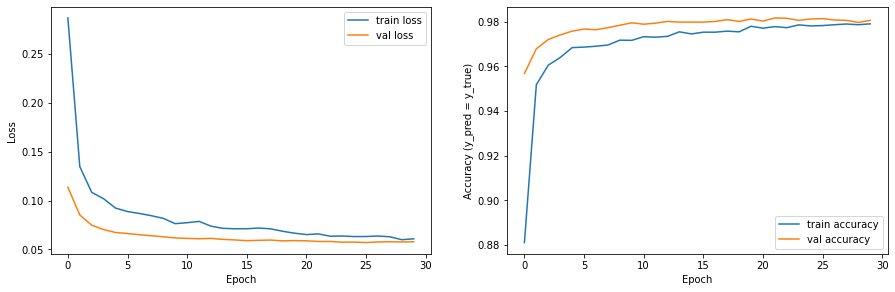

In [97]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [98]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

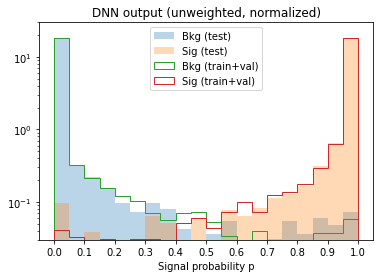

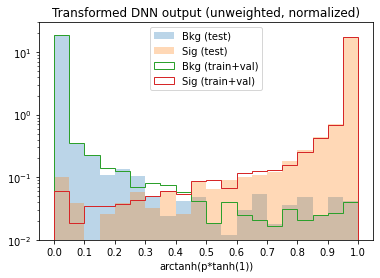

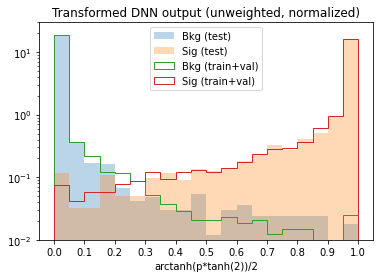

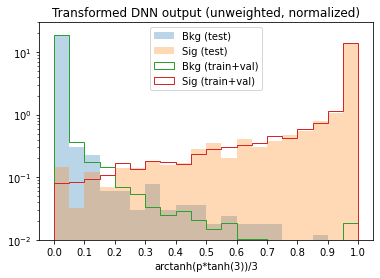

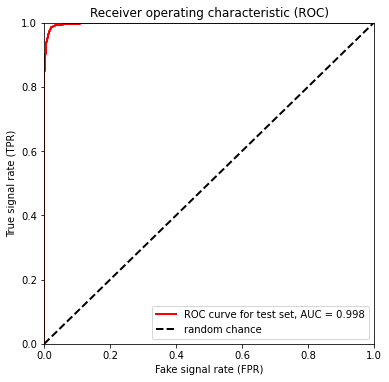

Test loss, test accuracy: [0.057111425615778755, 0.9804074168205261]


In [106]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(3e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 128)
print("Test loss, test accuracy:", results)

## Save trained model

In [ ]:
joblib.dump(scaler, 'trained_models/mt_scaler.gz')
model.save('trained_models/mt_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models/mt_scaler.gz')
savedmodel = keras.models.load_model('trained_models/mt_model')
savedmodel.summary()

# Write model prediction to root files

## Load all root files one by one

In [107]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/mt18_raw/'
outfolder18 = 'root_outputs/mt18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('mutau_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/mt17_raw/'
outfolder17 = 'root_outputs/mt17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('mutau_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/mt16_raw/'
outfolder16 = 'root_outputs/mt16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('mutau_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [108]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

root_raw/mt18_raw/DY.root
root_raw/mt18_raw/DY1.root
root_raw/mt18_raw/DY2.root
root_raw/mt18_raw/DY3.root
root_raw/mt18_raw/DY4.root
root_raw/mt18_raw/GGHTT.root
root_raw/mt18_raw/GGHWW.root
root_raw/mt18_raw/GGZHLLTT.root
root_raw/mt18_raw/GGZHNNTT.root
root_raw/mt18_raw/GGZHQQTT.root
root_raw/mt18_raw/GGZHWW.root
root_raw/mt18_raw/ST_tW_antitop.root
root_raw/mt18_raw/ST_tW_top.root
root_raw/mt18_raw/ST_t_antitop.root
root_raw/mt18_raw/ST_t_top.root
root_raw/mt18_raw/TTTo2L2Nu.root
root_raw/mt18_raw/TTToHadronic.root
root_raw/mt18_raw/TTToSemiLeptonic.root
root_raw/mt18_raw/VBFHTT.root
root_raw/mt18_raw/VBFHWW.root
root_raw/mt18_raw/VV2L2Nu.root
root_raw/mt18_raw/WZ2L2Q.root
root_raw/mt18_raw/WZ3LNu.root
root_raw/mt18_raw/WminusHTT.root
root_raw/mt18_raw/WminusHWW.root
root_raw/mt18_raw/WplusHTT.root
root_raw/mt18_raw/WplusHWW.root
root_raw/mt18_raw/ZHTT.root
root_raw/mt18_raw/ZHWW.root
root_raw/mt18_raw/ZZ2L2Q.root
root_raw/mt18_raw/ZZ4L.root
root_raw/mt18_raw/data_obs.root
root_raw

In [110]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

root_raw/mt17_raw/DY.root
root_raw/mt17_raw/DY1.root
root_raw/mt17_raw/DY2.root
root_raw/mt17_raw/DY3.root
root_raw/mt17_raw/DY4.root
root_raw/mt17_raw/GGHTT.root
root_raw/mt17_raw/GGHWW.root
root_raw/mt17_raw/GGZHLLTT.root
root_raw/mt17_raw/GGZHNNTT.root
root_raw/mt17_raw/GGZHQQTT.root
root_raw/mt17_raw/GGZHWW.root
root_raw/mt17_raw/ST_tW_antitop.root
root_raw/mt17_raw/ST_tW_top.root
root_raw/mt17_raw/ST_t_antitop.root
root_raw/mt17_raw/ST_t_top.root
root_raw/mt17_raw/TTTo2L2Nu.root
root_raw/mt17_raw/TTToHadronic.root
root_raw/mt17_raw/TTToSemiLeptonic.root
root_raw/mt17_raw/VBFHTT.root
root_raw/mt17_raw/VBFHWW.root
root_raw/mt17_raw/VV2L2Nu.root
root_raw/mt17_raw/WZ2L2Q.root
root_raw/mt17_raw/WZ3L1Nu.root
root_raw/mt17_raw/WminusHTT.root
root_raw/mt17_raw/WminusHWW.root
root_raw/mt17_raw/WplusHTT.root
root_raw/mt17_raw/WplusHWW.root
root_raw/mt17_raw/ZHTT.root
root_raw/mt17_raw/ZHWW.root
root_raw/mt17_raw/ZZ2L2Q.root
root_raw/mt17_raw/ZZ4L.root
root_raw/mt17_raw/data_obs.root
root_ra

In [112]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

root_raw/mt16_raw/DY.root
root_raw/mt16_raw/DY1.root
root_raw/mt16_raw/DY2.root
root_raw/mt16_raw/DY3.root
root_raw/mt16_raw/DY4.root
root_raw/mt16_raw/GGHTT.root
root_raw/mt16_raw/GGHWW.root
root_raw/mt16_raw/GGZHLLTT.root
root_raw/mt16_raw/GGZHNNTT.root
root_raw/mt16_raw/GGZHQQTT.root
root_raw/mt16_raw/GGZHWW.root
root_raw/mt16_raw/ST_tW_antitop.root
root_raw/mt16_raw/ST_tW_top.root
root_raw/mt16_raw/ST_t_antitop.root
root_raw/mt16_raw/ST_t_top.root
root_raw/mt16_raw/TT.root
root_raw/mt16_raw/VBFHTT.root
root_raw/mt16_raw/VBFHWW.root
root_raw/mt16_raw/VV2L2Nu.root
root_raw/mt16_raw/WZ2L2Q.root
root_raw/mt16_raw/WZ3L1Nu.root
root_raw/mt16_raw/WminusHTT.root
root_raw/mt16_raw/WminusHWW.root
root_raw/mt16_raw/WplusHTT.root
root_raw/mt16_raw/WplusHWW.root
root_raw/mt16_raw/ZHTT.root
root_raw/mt16_raw/ZHWW.root
root_raw/mt16_raw/ZZ2L2Q.root
root_raw/mt16_raw/ZZ4L.root
root_raw/mt16_raw/data_obs.root
root_raw/mt16_raw/embedded.root
root_raw/mt16_raw/ggH_bbtt15.root
root_raw/mt16_raw/ggH_bb

## Feed to NN and write outputs to root files

In [109]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('pred_2b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths18[i])

root_outputs/mt18_outputs/DY.root
root_outputs/mt18_outputs/DY1.root
root_outputs/mt18_outputs/DY2.root
root_outputs/mt18_outputs/DY3.root
root_outputs/mt18_outputs/DY4.root
root_outputs/mt18_outputs/GGHTT.root
root_outputs/mt18_outputs/GGHWW.root
root_outputs/mt18_outputs/GGZHLLTT.root
root_outputs/mt18_outputs/GGZHNNTT.root
root_outputs/mt18_outputs/GGZHQQTT.root
root_outputs/mt18_outputs/GGZHWW.root
root_outputs/mt18_outputs/ST_tW_antitop.root
root_outputs/mt18_outputs/ST_tW_top.root
root_outputs/mt18_outputs/ST_t_antitop.root
root_outputs/mt18_outputs/ST_t_top.root
root_outputs/mt18_outputs/TTTo2L2Nu.root
root_outputs/mt18_outputs/TTToHadronic.root
root_outputs/mt18_outputs/TTToSemiLeptonic.root
root_outputs/mt18_outputs/VBFHTT.root
root_outputs/mt18_outputs/VBFHWW.root
root_outputs/mt18_outputs/VV2L2Nu.root
root_outputs/mt18_outputs/WZ2L2Q.root
root_outputs/mt18_outputs/WZ3LNu.root
root_outputs/mt18_outputs/WminusHTT.root
root_outputs/mt18_outputs/WminusHWW.root
root_outputs/mt18_

In [111]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('pred_2b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths17[i])

root_outputs/mt17_outputs/DY.root
root_outputs/mt17_outputs/DY1.root
root_outputs/mt17_outputs/DY2.root
root_outputs/mt17_outputs/DY3.root
root_outputs/mt17_outputs/DY4.root
root_outputs/mt17_outputs/GGHTT.root
root_outputs/mt17_outputs/GGHWW.root
root_outputs/mt17_outputs/GGZHLLTT.root
root_outputs/mt17_outputs/GGZHNNTT.root
root_outputs/mt17_outputs/GGZHQQTT.root
root_outputs/mt17_outputs/GGZHWW.root
root_outputs/mt17_outputs/ST_tW_antitop.root
root_outputs/mt17_outputs/ST_tW_top.root
root_outputs/mt17_outputs/ST_t_antitop.root
root_outputs/mt17_outputs/ST_t_top.root
root_outputs/mt17_outputs/TTTo2L2Nu.root
root_outputs/mt17_outputs/TTToHadronic.root
root_outputs/mt17_outputs/TTToSemiLeptonic.root
root_outputs/mt17_outputs/VBFHTT.root
root_outputs/mt17_outputs/VBFHWW.root
root_outputs/mt17_outputs/VV2L2Nu.root
root_outputs/mt17_outputs/WZ2L2Q.root
root_outputs/mt17_outputs/WZ3L1Nu.root
root_outputs/mt17_outputs/WminusHTT.root
root_outputs/mt17_outputs/WminusHWW.root
root_outputs/mt17

In [113]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('pred_2b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths16[i])

root_outputs/mt16_outputs/DY.root
root_outputs/mt16_outputs/DY1.root
root_outputs/mt16_outputs/DY2.root
root_outputs/mt16_outputs/DY3.root
root_outputs/mt16_outputs/DY4.root
root_outputs/mt16_outputs/GGHTT.root
root_outputs/mt16_outputs/GGHWW.root
root_outputs/mt16_outputs/GGZHLLTT.root
root_outputs/mt16_outputs/GGZHNNTT.root
root_outputs/mt16_outputs/GGZHQQTT.root
root_outputs/mt16_outputs/GGZHWW.root
root_outputs/mt16_outputs/ST_tW_antitop.root
root_outputs/mt16_outputs/ST_tW_top.root
root_outputs/mt16_outputs/ST_t_antitop.root
root_outputs/mt16_outputs/ST_t_top.root
root_outputs/mt16_outputs/TT.root
root_outputs/mt16_outputs/VBFHTT.root
root_outputs/mt16_outputs/VBFHWW.root
root_outputs/mt16_outputs/VV2L2Nu.root
root_outputs/mt16_outputs/WZ2L2Q.root
root_outputs/mt16_outputs/WZ3L1Nu.root
root_outputs/mt16_outputs/WminusHTT.root
root_outputs/mt16_outputs/WminusHWW.root
root_outputs/mt16_outputs/WplusHTT.root
root_outputs/mt16_outputs/WplusHWW.root
root_outputs/mt16_outputs/ZHTT.root
